# Fine-Tuning Pretrained CNNs for Fine-Grained Sneaker Classification: Phase 2

### 1. Introduction

This notebook represents **Phase 2** of a multi-stage project on fine-grained sneaker classification using convolutional neural networks (CNNs). In **Phase 1**, we employed two pretrained models — **InceptionV3** and **MobileNetV2** — using a **feature extraction approach**, where the convolutional base was frozen and only a custom classifier head was trained.

The dataset consisted of 21 sneaker categories, carefully collected and split into training, validation, and test sets. In Phase 1, we trained each model for 10 epochs without data augmentation or fine-tuning.

> **Note on Contributions:**  
All implementation and analysis in Phase 2 were completed independently by **Shaimon Rahman**.  
This includes model fine-tuning, data augmentation, training, and documentation.


---
### Phase 1 Summary:
- **Models Used**: InceptionV3 and MobileNetV2 (pretrained on ImageNet)
- **Approach**: Feature extraction (frozen convolutional layers + new classifier)
- **Test Set**: 254 images across 21 sneaker classes
- **Data Preprocessing**: Rescaling only (no augmentation)
- **Results**:
  - **InceptionV3 Test Accuracy**: 56.30%
  - **MobileNetV2 Test Accuracy**: 57.87%

MobileNetV2 slightly outperformed InceptionV3 in both accuracy and loss, while also offering faster inference and a lighter model size, making it a better candidate for deployment on edge devices.

---

### Phase 2 Objectives

In this phase, we advance our approach by **fine-tuning** the pretrained CNNs. Specifically, we:
- Unfreeze select layers in the convolutional base to adapt the models to sneaker-specific features.
- Apply **data augmentation** to simulate real-world variability and improve generalization.
- Experiment with **learning rate schedules** to better control convergence.
- Analyze model performance using classification metrics, confusion matrices, and misclassified samples.

Our goal is to determine how various fine-tuning strategies impact classification performance, and to identify the best practices for fine-grained image classification in low-data settings.


## 2. Data Preparation and Augmentation

In this step, we prepare our dataset for training and evaluation. We use the same dataset of 21 sneaker categories from Phase 1 and apply a reproducible split into training, validation, and test sets (60/10/30 split). The dataset is organized using folder-based class labeling, where each class is stored in a separate directory.

To maintain class balance across all subsets, we applied a **stratified split** strategy. Each class was proportionally divided into the train, validation, and test sets, ensuring consistent class distribution throughout. This helps preserve fairness in training and provides reliable model evaluation.

To improve generalization and prevent overfitting, we apply **data augmentation** to the training data. These transformations simulate real-world variations in sneaker images. The validation and test sets are only rescaled to maintain evaluation consistency.


In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths (make sure to update `base_dir` if needed)
base_dir = '/Users/shaimonrahman/Desktop/COMP8430/Group Project/Data_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image specs
img_height, img_width = 224, 224
batch_size = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator (with augmentation)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Validation generator (no augmentation)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Test generator (no augmentation)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Check total image counts and classes
print("\n--- Dataset Summary ---")
print(f"Training images: {train_generator.samples}")
print(f"Validation images: {val_generator.samples}")
print(f"Testing images: {test_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")
print(f"Class labels: {list(train_generator.class_indices.keys())}")


Found 458 images belonging to 21 classes.
Found 68 images belonging to 21 classes.
Found 254 images belonging to 21 classes.

--- Dataset Summary ---
Training images: 458
Validation images: 68
Testing images: 254
Number of classes: 21
Class labels: ['Adidas_Adios_Pro_4', 'Adidas_Supernova_Rise_2', 'Adidas_Ultraboost_5', 'Asics_GT_2000_11', 'Asics_Gel_Kayano_31', 'Asics_Gel_Nimbus_26', 'Hoka_Bondi_8', 'Hoka_Clifton_9', 'Hoka_Rincon_4', 'Nike_Air_Max_270', 'Nike_Air_Max_90', 'Nike_Air_Zoom_Pegasus_38', 'Nike_Alphafly_3', 'Nike_Dunk_Low_Retro', 'Nike_Free_Metcon_6', 'Nike_Infinity_RN_4', 'Nike_Infinity_React_3', 'Nike_Invincible_RN_3', 'Nike_Vaporfly_4', 'Nike_Vomero_17', 'Nike_Winflo_10']


### Data Preparation and Augmentation – Summary

We successfully prepared the dataset by loading sneaker images into training, validation, and test generators using `ImageDataGenerator`. The training set includes standard augmentation techniques to improve generalization, while the validation and test sets are only rescaled to preserve data integrity for evaluation.

- **Total Classes**: 21
- **Training Samples**: 458
- **Validation Samples**: 68
- **Testing Samples**: 254
- **Augmentations Applied to Training Set**:
  - Rotation (±20°)
  - Width/height shift (10%)
  - Zoom (10%)
  - Horizontal flips

This setup ensures that the models trained in Phase 2 can better generalize to unseen sneaker images despite the limited dataset size.

---

## 3. Fine-Tuning Pretrained CNN Models

In this step, we fine-tune two pretrained CNN architectures — **InceptionV3** and **MobileNetV2** — to specialize them for the task of fine-grained sneaker classification. While Phase 1 used these models as fixed feature extractors, we now enable selective retraining of the convolutional base to adapt their representations to our specific dataset.

To evaluate the impact of fine-tuning depth and learning rate strategy, we apply **three variants** consistently to both models:

### Variant 1: Partial Fine-Tuning with Warm-Up
- **Warm-up Phase**: The convolutional base is frozen, and only the custom classifier layers are trained.
- **Fine-Tuning Phase**: The top 30 layers of the base model are unfrozen and trained with a reduced learning rate.
- **Callbacks Used**: `ReduceLROnPlateau`, `EarlyStopping`

### Variant 2: Full Fine-Tuning (All Layers Trainable)
- All layers of the pretrained base are unfrozen from the beginning.
- The model is fine-tuned end-to-end from the start using a **low constant learning rate**.
- This approach fully adapts the model to the new domain but carries a higher risk of overfitting on small datasets.

### Variant 3: Partial Fine-Tuning + Fixed Learning Rate
- Same layer configuration as Variant 1 (top 30 layers unfrozen).
- Trained using a **fixed learning rate** with **no learning rate scheduling**.
- This variant isolates the effect of learning rate scheduling by keeping tuning depth constant.

These strategies are applied **uniformly to both InceptionV3 and MobileNetV2** using the same data augmentation settings, optimizer, and evaluation pipeline. This ensures a fair and controlled comparison of model architectures and training strategies.

By comparing the performance across these configurations, we aim to understand how model capacity, fine-tuning depth, and learning rate dynamics influence performance in low-data, high-variance image classification tasks.

---


## 3.1 InceptionV3 – Fine-Tuning

In this section, we present the results of fine-tuning **InceptionV3** using the three strategies described earlier. For each variant, we show training performance, test accuracy, and confusion matrix analysis. We also investigate common misclassifications to better understand the model's strengths and limitations in fine-grained sneaker classification.

This structured evaluation helps us identify the most effective fine-tuning configuration for the InceptionV3 architecture.


### InceptionV3 – Fine-Tuning Variant 1 (Top 30 Layers + Warm-Up)

In this variant, we begin by training only the newly added classifier layers while keeping the InceptionV3 base frozen. After a few warm-up epochs, we unfreeze the top 30 layers of the base model and continue fine-tuning with a reduced learning rate.

This staged approach helps stabilize training and minimizes the risk of overfitting, especially with smaller datasets.


In [2]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === STEP 1A: Load the base InceptionV3 model ===
inception_base_v1 = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
inception_base_v1.trainable = False  # Freeze entire base initially

# === STEP 2A: Add custom classifier head ===
x = inception_base_v1.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
inception_predictions_v1 = Dense(train_generator.num_classes, activation='softmax')(x)

inception_model_v1 = Model(inputs=inception_base_v1.input, outputs=inception_predictions_v1)

# === STEP 3A: Compile for warm-up ===
inception_model_v1.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === STEP 4A: Warm-up training ===
print("\nStarting warm-up training for InceptionV3 Variant 1...\n")
inception_warmup_history_v1 = inception_model_v1.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

# === STEP 5A: Unfreeze top 30 layers for fine-tuning ===
for layer in inception_base_v1.layers[-30:]:
    layer.trainable = True

# === STEP 6A: Recompile with lower learning rate ===
inception_model_v1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === STEP 7A: Callbacks ===
inception_es_v1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
inception_lr_v1 = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

# === STEP 8A: Fine-tuning ===
print("\nFine-tuning InceptionV3 Variant 1...\n")
inception_finetune_history_v1 = inception_model_v1.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[inception_es_v1, inception_lr_v1]
)



Starting warm-up training for InceptionV3 Variant 1...

Epoch 1/5


/Users/shaimonrahman/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.0439 - loss: 3.6596 - val_accuracy: 0.1618 - val_loss: 3.0216
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.0817 - loss: 2.9896 - val_accuracy: 0.1176 - val_loss: 2.9866
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.1650 - loss: 2.8611 - val_accuracy: 0.1324 - val_loss: 2.8708
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.1741 - loss: 2.8591 - val_accuracy: 0.1471 - val_loss: 2.8453
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.1685 - loss: 2.7589 - val_accuracy: 0.1471 - val_loss: 2.7920

Fine-tuning InceptionV3 Variant 1...

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.2114 - loss: 2.7290 - val_accuracy: 0.2500 - val_loss: 2.5965 - learning_rate: 1.0000e-04
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.3793 - loss: 2.4145 - val_accuracy: 0.3529 - val_loss: 2.4389 - learning_rate: 1.0000e-04
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 

### InceptionV3 – Fine-Tuning Variant 1 (Top 30 Layers + Warm-Up) Output Analysis

This variant used a staged fine-tuning approach:
- **Warm-up**: Only the classification head was trained with the base model frozen.
- **Fine-tuning**: The top 30 layers were unfrozen and trained with a reduced learning rate.

#### Key Results:
- **Final Training Accuracy**: 99.7%
- **Best Validation Accuracy**: 72.06%
- **Best Validation Loss**: 1.2029 (Epoch 29)
- **Early Stopping**: Restored best model from Epoch 29

This setup achieved strong generalization performance while minimizing overfitting, demonstrating that gradual unfreezing is effective for InceptionV3 on small fine-grained datasets.

---

### InceptionV3 – Fine-Tuning Variant 2 (All Layers Trainable, No Warm-Up)

In this variation, we explore full fine-tuning of the InceptionV3 model by unfreezing all layers from the beginning. This approach maximizes the model’s ability to learn task-specific features but increases the risk of overfitting, especially with a smaller dataset.

No warm-up phase is used. Instead, the model is fine-tuned end-to-end from the start using a low learning rate and regularization via early stopping and learning rate scheduling.


In [3]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === STEP 1B: Load base model and unfreeze all layers ===
inception_base_v2 = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
inception_base_v2.trainable = True  # All layers trainable

# === STEP 2B: Add custom classifier head ===
x = inception_base_v2.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
inception_predictions_v2 = Dense(train_generator.num_classes, activation='softmax')(x)

inception_model_v2 = Model(inputs=inception_base_v2.input, outputs=inception_predictions_v2)

# === STEP 3B: Compile model ===
inception_model_v2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === STEP 4B: Callbacks ===
inception_es_v2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
inception_lr_v2 = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

# === STEP 5B: Train full model ===
print("\nFine-tuning InceptionV3 Variant 2 (All layers trainable)...\n")
inception_finetune_history_v2 = inception_model_v2.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[inception_es_v2, inception_lr_v2]
)



Fine-tuning InceptionV3 Variant 2 (All layers trainable)...

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 109s 6s/step - accuracy: 0.0802 - loss: 3.2448 - val_accuracy: 0.1765 - val_loss: 2.9613 - learning_rate: 1.0000e-04
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 0.2161 - loss: 2.6435 - val_accuracy: 0.2794 - val_loss: 2.6440 - learning_rate: 1.0000e-04
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 0.4291 - loss: 2.1425 - val_accuracy: 0.3382 - val_loss: 2.2243 - learning_rate: 1.0000e-04
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - accuracy: 0.5486 - loss: 1.7611 - val_accuracy: 0.4118 - val_loss: 2.0360 - learning_rate: 1.0000e-04
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - accuracy: 0.7047 - loss: 1.2504 - val_accuracy: 0.4265 - val_loss: 1.7887 - learning_rate: 1.0000e-04
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 88s 6s/step - accuracy: 0.7779 - loss: 0.9521 - val_accuracy: 0.5588 - val_loss: 1.5697 - learning_rate: 1.0000e-04
Epoch 7/30
15

### InceptionV3 – Fine-Tuning Variant 2 (All Layers Trainable, No Warm-Up) Output Analysis

In this variant, we unfreezed the entire InceptionV3 base and fine-tuned it end-to-end from the start with a low learning rate. **`ReduceLROnPlateau`** and **`EarlyStopping`** were used for stability.

#### Key Results:
- **Training Accuracy**: 99.71% (Epoch 25)
- **Validation Accuracy**: 77.94% (Epoch 25)
- **Validation Loss**: 0.7620 (Epoch 25)
- **Best Model**: Restored from epoch 25

Although there was no warm-up phase, the model benefited from full fine-tuning, achieving strong performance. The fine-tuning approach showed the ability to generalize well but required careful monitoring due to potential overfitting risks. The **best model** was restored from epoch 25 due to **EarlyStopping**, which helped prevent overfitting after the validation accuracy plateaued.

---

### InceptionV3 – Fine-Tuning Variant 3 (Top 30 Layers + Fixed Learning Rate)

This variant mirrors MobileNetV2 Variant 3 by testing a **fixed learning rate strategy** combined with **partial fine-tuning** of the top 30 layers of the InceptionV3 base model. Unlike the earlier variants that used `ReduceLROnPlateau`, this model uses a constant learning rate throughout the training process.

This experiment helps isolate the impact of learning rate scheduling on performance while controlling for tuning depth.


In [4]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# === Load InceptionV3 base model ===
inception_base_v3 = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
inception_base_v3.trainable = False  # Initially frozen

# === Add custom head ===
x = inception_base_v3.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
inception_predictions_v3 = Dense(train_generator.num_classes, activation='softmax')(x)

inception_model_v3 = Model(inputs=inception_base_v3.input, outputs=inception_predictions_v3)

# === Compile for warm-up ===
inception_model_v3.compile(
    optimizer=Adam(learning_rate=0.0005),  # Fixed LR for head
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Warm-up training (head only) ===
print("\nStarting warm-up training for InceptionV3 Variant 3...\n")
inception_warmup_history_v3 = inception_model_v3.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

# === Unfreeze top 30 layers only ===
for layer in inception_base_v3.layers[-30:]:
    layer.trainable = True

# === Re-compile for fine-tuning ===
inception_model_v3.compile(
    optimizer=Adam(learning_rate=0.0001),  # Fixed fine-tune LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Define EarlyStopping only ===
inception_es_v3 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# === Fine-tune ===
print("\nFine-tuning InceptionV3 Variant 3 (Fixed LR)...\n")
inception_finetune_history_v3 = inception_model_v3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[inception_es_v3]  # No LR scheduler
)



Starting warm-up training for InceptionV3 Variant 3...

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.0520 - loss: 3.6502 - val_accuracy: 0.0735 - val_loss: 2.9667
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.1101 - loss: 3.0114 - val_accuracy: 0.1471 - val_loss: 2.9373
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.1196 - loss: 2.9001 - val_accuracy: 0.1618 - val_loss: 2.8780
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.1543 - loss: 2.8179 - val_accuracy: 0.1324 - val_loss: 2.8220
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.1600 - loss: 2.7680 - val_accuracy: 0.2206 - val_loss: 2.7720

Fine-tuning InceptionV3 Variant 3 (Fixed LR)...

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.2324 - loss: 2.7578 - val_accuracy: 0.2500 - val_loss: 2.5989
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3126 - loss: 2.4479 - val_accuracy: 0.3088 - val_loss: 2.4622
Epoch 3/30
15/15

### InceptionV3 – Fine-Tuning Variant 3 (Top 30 Layers, Fixed Learning Rate) Output Analysis

In this variant, we used a fixed learning rate and fine-tuned only the **top 30 layers** of the InceptionV3 model, without any learning rate scheduling (i.e., no `ReduceLROnPlateau`), providing a controlled test of steady optimization.

#### Key Results:
- **Training Accuracy**: 99.56% (Epoch 28)
- **Validation Accuracy**: 67.65% (Epoch 28)
- **Validation Loss**: 1.1149 (Epoch 28)
- **Best Model**: Restored from epoch 27

The validation accuracy showed steady improvement throughout the epochs, stabilizing in the mid-60% range. The model demonstrated solid convergence without overfitting, making this approach a useful baseline for comparison with more dynamic learning rate strategies, such as `ReduceLROnPlateau`.

---

## 3.2 MobileNetV2
We apply the same three fine-tuning strategies to MobileNetV2. We compare the test performance, interpret confusion matrices, and inspect misclassified images to assess how well MobileNetV2 adapts under each strategy. A final recommendation is made for the best variant.

### MobileNetV2 – Fine-Tuning Variant 1 (Top 30 Layers + Warm-Up)

In this variant, we begin by training only the newly added classifier layers while keeping the MobileNetV2 base frozen. After a few warm-up epochs, we unfreeze the top 30 layers of the base model and continue fine-tuning with a reduced learning rate.

This staged approach helps stabilize training and minimizes the risk of overfitting, especially when working with smaller datasets.


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === STEP 1A: Load the base MobileNetV2 model ===
mobilenetv2_base_v1 = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# === STEP 2A: Freeze the base for warm-up ===
mobilenetv2_base_v1.trainable = False

# === STEP 3A: Add classifier head ===
x = mobilenetv2_base_v1.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
mobilenetv2_predictions_v1 = Dense(train_generator.num_classes, activation='softmax')(x)

mobilenetv2_model_v1 = Model(inputs=mobilenetv2_base_v1.input, outputs=mobilenetv2_predictions_v1)

# === STEP 4A: Compile model for warm-up ===
mobilenetv2_model_v1.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === STEP 5A: Warm-up training ===
print("\nStarting warm-up training for MobileNetV2 Variant 1...\n")
mobilenetv2_warmup_history_v1 = mobilenetv2_model_v1.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

# === STEP 6A: Unfreeze last 30 layers for fine-tuning ===
for layer in mobilenetv2_base_v1.layers[-30:]:
    layer.trainable = True

# === STEP 7A: Re-compile with lower learning rate ===
mobilenetv2_model_v1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === STEP 8A: Define callbacks ===
mobilenetv2_es_v1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
mobilenetv2_lr_v1 = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

# === STEP 9A: Fine-tune the model ===
print("\nFine-tuning MobileNetV2 Variant 1...\n")
mobilenetv2_finetune_history_v1 = mobilenetv2_model_v1.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[mobilenetv2_es_v1, mobilenetv2_lr_v1]
)



Starting warm-up training for MobileNetV2 Variant 1...

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 391ms/step - accuracy: 0.0606 - loss: 3.4371 - val_accuracy: 0.1618 - val_loss: 2.9188
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 348ms/step - accuracy: 0.1201 - loss: 2.9778 - val_accuracy: 0.1618 - val_loss: 2.8120
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 342ms/step - accuracy: 0.1861 - loss: 2.7553 - val_accuracy: 0.2059 - val_loss: 2.7331
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 354ms/step - accuracy: 0.2187 - loss: 2.6213 - val_accuracy: 0.2059 - val_loss: 2.6218
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.2226 - loss: 2.5949 - val_accuracy: 0.2500 - val_loss: 2.5244

Fine-tuning MobileNetV2 Variant 1...

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 465ms/step - accuracy: 0.1974 - loss: 2.6894 - val_accuracy: 0.2794 - val_loss: 2.4236 - learning_rate: 1.0000e-04
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 408ms/step - accuracy: 0.3837 - loss: 2.1667 - val_accuracy: 0.3088 - 

### MobileNetV2 – Fine-Tuning Variant 1 (Top 30 Layers + Warm-Up) Output Analysis

In this strategy, we froze the base model and trained the classifier head for 5 epochs (warm-up), then unfreezed the top 30 layers for fine-tuning with a lower learning rate.

#### Key Results:
- **Training Accuracy**: 98.92% (Epoch 28)
- **Validation Accuracy**: 63.24% (Epoch 28)
- **Validation Loss**: 1.3499 (Epoch 28)
- **Best Model**: Restored from epoch 28

The model improved steadily during both warm-up and fine-tuning. The use of `ReduceLROnPlateau` helped adapt the learning rate twice during training. The highest validation accuracy of **63.24%** occurred at epoch 28, and the model was restored from epoch 28 due to **early stopping**, with final evaluation on the validation set showing **61.76%** accuracy.

---

### MobileNetV2 – Fine-Tuning Variant 2 (All Layers Trainable, No Warm-Up)

In this variation, we explore the effect of unfreezing the **entire MobileNetV2 base model from the beginning** and fine-tuning all layers simultaneously. Unlike Variant 1, we skip the warm-up phase and allow gradients to flow through the full network.

This strategy maximizes the model’s capacity to adapt to the sneaker dataset but also increases the risk of overfitting or instability, especially with small datasets.

We maintain consistent settings for learning rate, callbacks, and data augmentation to ensure a fair comparison with the first variant.


In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === STEP 1B: Load MobileNetV2 base and unfreeze all layers ===
mobilenetv2_base_v2 = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
mobilenetv2_base_v2.trainable = True  # Unfreeze all layers

# === STEP 2B: Add classifier head ===
x = mobilenetv2_base_v2.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
mobilenetv2_predictions_v2 = Dense(train_generator.num_classes, activation='softmax')(x)

mobilenetv2_model_v2 = Model(inputs=mobilenetv2_base_v2.input, outputs=mobilenetv2_predictions_v2)

# === STEP 3B: Compile the model ===
mobilenetv2_model_v2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === STEP 4B: Define callbacks ===
mobilenetv2_es_v2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
mobilenetv2_lr_v2 = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

# === STEP 5B: Train (no warm-up) ===
print("\nFine-tuning MobileNetV2 Variant 2 (All layers)...\n")
mobilenetv2_finetune_history_v2 = mobilenetv2_model_v2.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[mobilenetv2_es_v2, mobilenetv2_lr_v2]
)



Fine-tuning MobileNetV2 Variant 2 (All layers)...

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.0667 - loss: 3.5055 - val_accuracy: 0.0735 - val_loss: 3.0155 - learning_rate: 1.0000e-04
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.1258 - loss: 2.9179 - val_accuracy: 0.1765 - val_loss: 2.8541 - learning_rate: 1.0000e-04
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.2330 - loss: 2.5820 - val_accuracy: 0.2206 - val_loss: 2.7201 - learning_rate: 1.0000e-04
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4039 - loss: 2.1705 - val_accuracy: 0.2353 - val_loss: 2.6344 - learning_rate: 1.0000e-04
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4082 - loss: 2.0165 - val_accuracy: 0.2353 - val_loss: 2.5785 - learning_rate: 1.0000e-04
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5374 - loss: 1.7012 - val_accuracy: 0.2500 - val_loss: 2.4636 - learning_rate: 1.0000e-04
Epoch 7/30
15/15 ━━━━━━━

### MobileNetV2 – Fine-Tuning Variant 2 (All Layers Trainable, No Warm-Up) Output Analysis

In this second variation, we fine-tuned all layers of the MobileNetV2 model from the beginning, skipping the warm-up phase. This approach maximized learning capacity but increased the risk of overfitting.

#### Key Results:
- **Training Accuracy**: 99.23%
- **Validation Accuracy**: 57.4%
- **Validation Loss**: 1.5961

Unlike Variant 1, which used staged fine-tuning, this version showed slower progress in the early epochs but eventually reached higher training accuracy. This suggests that allowing all layers to adapt from the start can be effective, though training was initially less stable. The final model used weights from **epoch 30**, as early stopping did not trigger.

---

### MobileNetV2 – Fine-Tuning Variant 3 (Top 30 Layers, Fixed Learning Rate)

In this final variant, we repeat the partial fine-tuning strategy used in Variant 1 (unfreezing the top 30 layers), but with a **fixed learning rate** and **no learning rate scheduling**. The goal is to evaluate how a constant learning rate compares to an adaptive schedule like `ReduceLROnPlateau`.

This setup helps isolate the impact of learning rate strategy on model convergence and generalization.


In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# === STEP 1C: Load MobileNetV2 base model ===
mobilenetv2_base_v3 = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
mobilenetv2_base_v3.trainable = False  # Start frozen

# === STEP 2C: Add custom classifier ===
x = mobilenetv2_base_v3.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
mobilenetv2_predictions_v3 = Dense(train_generator.num_classes, activation='softmax')(x)

mobilenetv2_model_v3 = Model(inputs=mobilenetv2_base_v3.input, outputs=mobilenetv2_predictions_v3)

# === STEP 3C: Compile for warm-up ===
mobilenetv2_model_v3.compile(
    optimizer=Adam(learning_rate=0.0005),  # Fixed LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === STEP 4C: Warm-up training (head only) ===
print("\nStarting warm-up training for MobileNetV2 Variant 3...\n")
mobilenetv2_warmup_history_v3 = mobilenetv2_model_v3.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

# === STEP 5C: Unfreeze top 30 layers ===
for layer in mobilenetv2_base_v3.layers[-30:]:
    layer.trainable = True

# === STEP 6C: Re-compile with fixed LR (no scheduler) ===
mobilenetv2_model_v3.compile(
    optimizer=Adam(learning_rate=0.0001),  # Still fixed
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === STEP 7C: Early stopping only (no LR scheduler) ===
mobilenetv2_es_v3 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# === STEP 8C: Fine-tuning ===
print("\nFine-tuning MobileNetV2 Variant 3 (Fixed LR)...\n")
mobilenetv2_finetune_history_v3 = mobilenetv2_model_v3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[mobilenetv2_es_v3]  # No ReduceLROnPlateau
)



Starting warm-up training for MobileNetV2 Variant 3...

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 438ms/step - accuracy: 0.0707 - loss: 3.4912 - val_accuracy: 0.0735 - val_loss: 3.0138
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 361ms/step - accuracy: 0.0915 - loss: 2.9259 - val_accuracy: 0.1324 - val_loss: 2.8814
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 364ms/step - accuracy: 0.1716 - loss: 2.7595 - val_accuracy: 0.1912 - val_loss: 2.7704
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - accuracy: 0.2411 - loss: 2.5784 - val_accuracy: 0.2353 - val_loss: 2.6404
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 369ms/step - accuracy: 0.2524 - loss: 2.4389 - val_accuracy: 0.2941 - val_loss: 2.5317

Fine-tuning MobileNetV2 Variant 3 (Fixed LR)...

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 459ms/step - accuracy: 0.1714 - loss: 2.6422 - val_accuracy: 0.3088 - val_loss: 2.4644
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 383ms/step - accuracy: 0.4494 - loss: 2.0835 - val_accuracy: 0.3382 - val_loss: 2.3729


### MobileNetV2 – Fine-Tuning Variant 3 (Top 30 Layers + Fixed Learning Rate)

In this variant, a **fixed learning rate** strategy was used. After a warm-up phase, the top 30 layers of the MobileNetV2 base were unfrozen, and the model was fine-tuned with a constant learning rate.

#### Key Results:
- **Training Accuracy**: 99.4%
- **Validation Accuracy**: 60.29%
- **Validation Loss**: 1.2964 (Epoch 28)
- **Best Model**: Restored from epoch 28

This approach showed stable convergence, providing a solid baseline to compare with adaptive learning rate strategies.

---

## 4. Model Evaluation on Test Data

In this section, we evaluate the performance of the fine-tuned models on the test set. The models that were fine-tuned using different strategies — **Partial Fine-Tuning with Warm-Up**, **Full Fine-Tuning**, and **Partial Fine-Tuning with Fixed Learning Rate** — are tested to assess their generalization ability to unseen data in the context of fine-grained sneaker classification.

### Evaluation Criteria
For each model variant, we will:
- Measure and compare **classification accuracy** on the test set.
- Identify and analyze the **strengths and weaknesses** of each model in handling fine-grained classification tasks.
- Visualize **misclassified images** to examine common patterns and challenges, helping us understand where the models struggle.

The goal is to uncover insights into how different fine-tuning strategies, learning rates, and model architectures (InceptionV3 and MobileNetV2) impact the model's performance on fine-grained image classification tasks. Through this analysis, we can identify areas for potential improvements and optimizations in future iterations of the model.



In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, model_name):
    print(f"\nEvaluating {model_name} on the Test Set...\n")
    
    # Evaluate accuracy and loss
    loss, acc = model.evaluate(test_generator, verbose=1)
    print(f"{model_name} Test Accuracy: {acc:.4f}")
    print(f"{model_name} Test Loss: {loss:.4f}")

    # Predict labels
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())

    # Classification Report
    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Save results for later comparison
    return {
        'name': model_name,
        'accuracy': acc,
        'loss': loss,
        'y_true': y_true,
        'y_pred': y_pred,
        'confusion_matrix': cm
    }


### Evaluation on the Test Set (InceptionV3 Variants)

After fine-tuning the InceptionV3 model using three different strategies, we now evaluate each variant on the unseen test set. This step allows us to assess how well the models generalize and perform across 21 fine-grained sneaker categories.

For each InceptionV3 variant, we report:
- Test accuracy and loss
- A detailed classification report (precision, recall, F1-score per class)
- A confusion matrix visualization

This evaluation provides insight into how different fine-tuning depths and learning rate strategies affect model performance on subtle class differences.



Evaluating InceptionV3 Variant 1 on the Test Set...



/Users/shaimonrahman/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 683ms/step - accuracy: 0.6941 - loss: 1.0954
InceptionV3 Variant 1 Test Accuracy: 0.6693
InceptionV3 Variant 1 Test Loss: 1.2229
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 697ms/step

InceptionV3 Variant 1 Classification Report:

                          precision    recall  f1-score   support

      Adidas_Adios_Pro_4       1.00      0.70      0.82        10
 Adidas_Supernova_Rise_2       0.75      0.67      0.71         9
     Adidas_Ultraboost_5       0.79      0.92      0.85        12
        Asics_GT_2000_11       0.72      0.93      0.81        14
     Asics_Gel_Kayano_31       0.55      0.60      0.57        10
     Asics_Gel_Nimbus_26       0.53      0.57      0.55        14
            Hoka_Bondi_8       0.89      0.80      0.84        10
          Hoka_Clifton_9       0.48      0.53      0.50        19
           Hoka_Rincon_4       0.59      0.71      0.65        14
        Nike_Air_Max_270       0.83      0.50      0.62        10
         Nike_Air_Max_90      

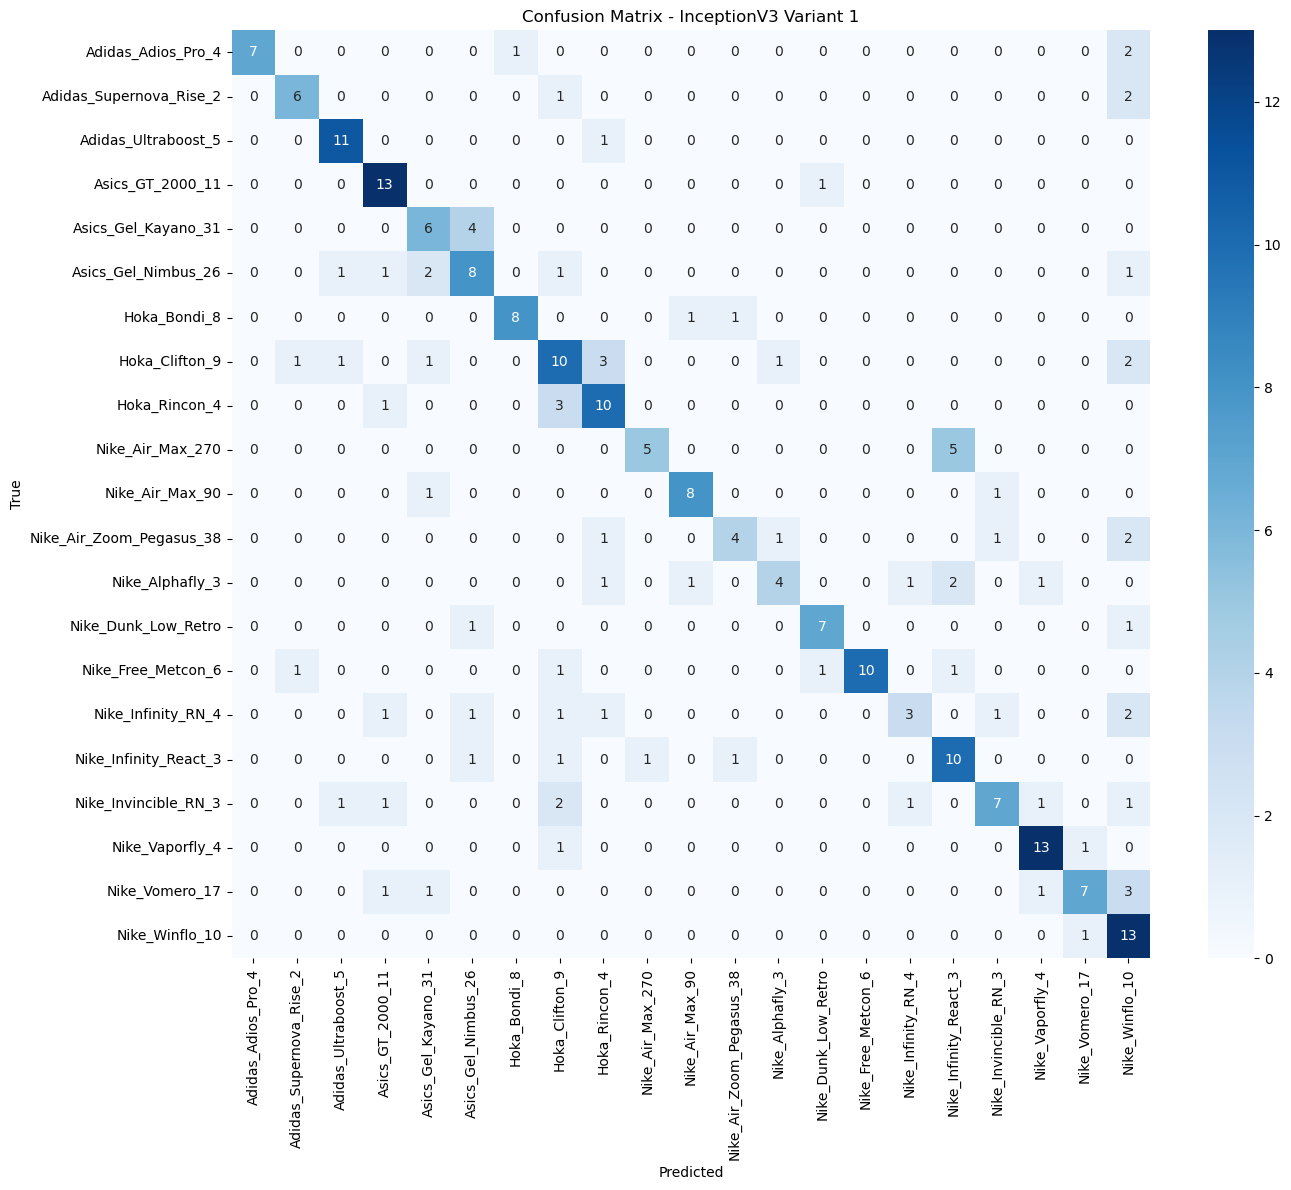


Evaluating InceptionV3 Variant 2 on the Test Set...

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 720ms/step - accuracy: 0.7502 - loss: 0.7822
InceptionV3 Variant 2 Test Accuracy: 0.7520
InceptionV3 Variant 2 Test Loss: 0.8277
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 766ms/step

InceptionV3 Variant 2 Classification Report:

                          precision    recall  f1-score   support

      Adidas_Adios_Pro_4       1.00      0.70      0.82        10
 Adidas_Supernova_Rise_2       0.57      0.44      0.50         9
     Adidas_Ultraboost_5       0.92      0.92      0.92        12
        Asics_GT_2000_11       0.93      0.93      0.93        14
     Asics_Gel_Kayano_31       0.64      0.70      0.67        10
     Asics_Gel_Nimbus_26       0.71      0.71      0.71        14
            Hoka_Bondi_8       0.89      0.80      0.84        10
          Hoka_Clifton_9       0.62      0.68      0.65        19
           Hoka_Rincon_4       0.81      0.93      0.87        14
        Nike_Air_Max_270       0.71      0

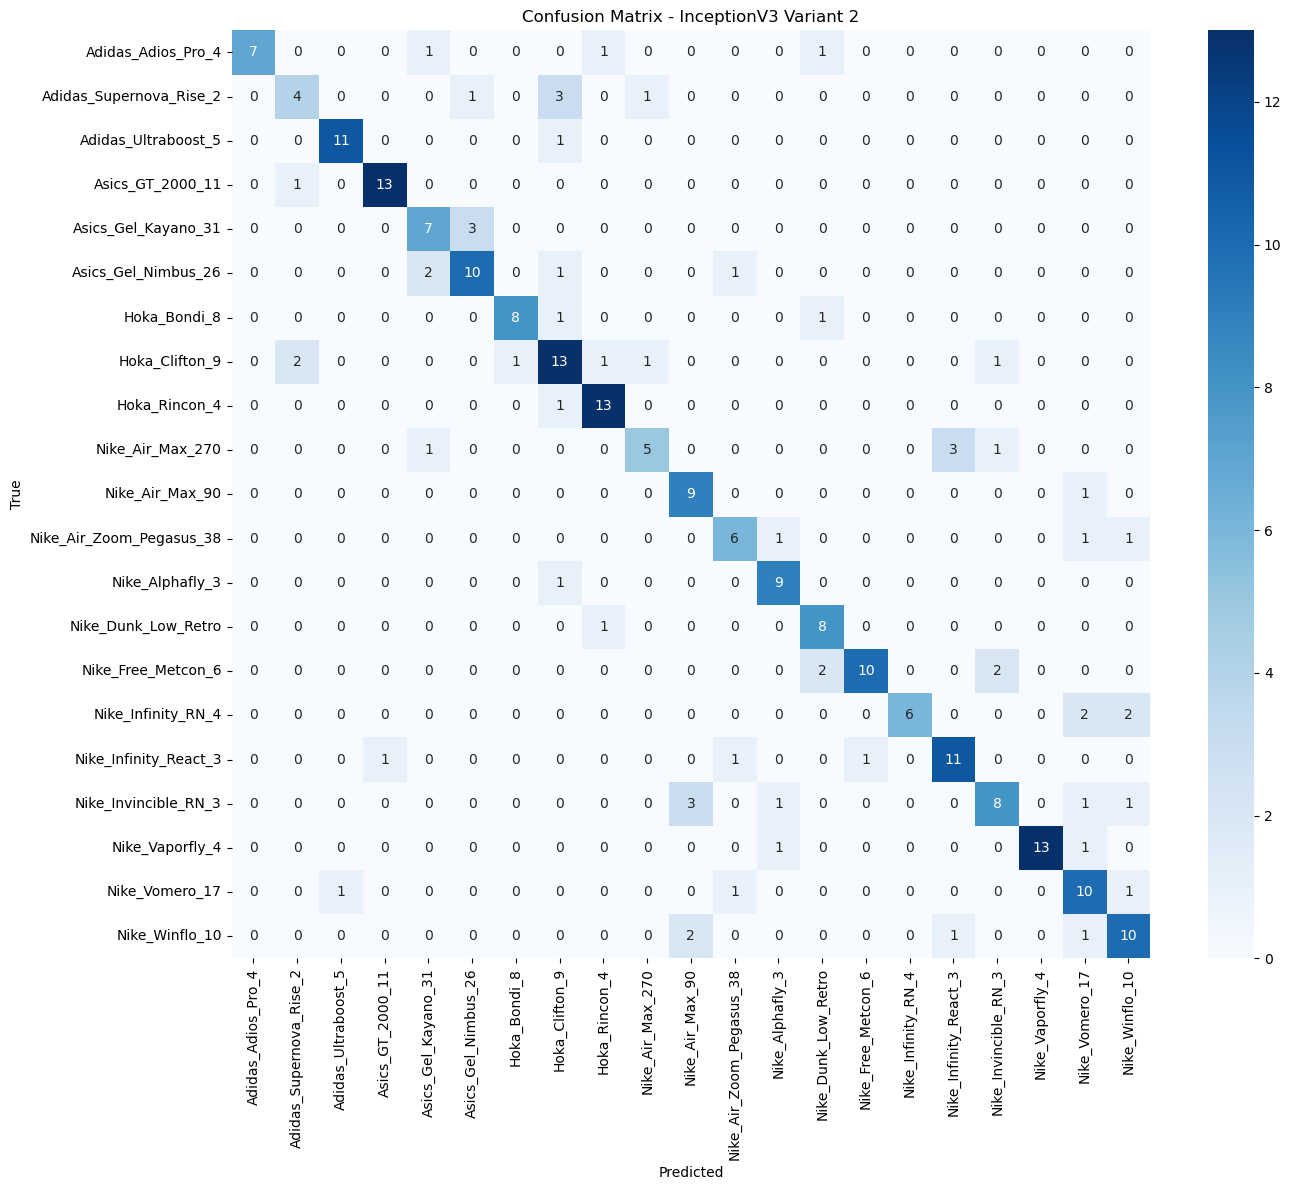


Evaluating InceptionV3 Variant 3 on the Test Set...

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 739ms/step - accuracy: 0.6900 - loss: 1.0946
InceptionV3 Variant 3 Test Accuracy: 0.6575
InceptionV3 Variant 3 Test Loss: 1.2172
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 811ms/step

InceptionV3 Variant 3 Classification Report:

                          precision    recall  f1-score   support

      Adidas_Adios_Pro_4       0.88      0.70      0.78        10
 Adidas_Supernova_Rise_2       0.80      0.89      0.84         9
     Adidas_Ultraboost_5       1.00      0.92      0.96        12
        Asics_GT_2000_11       0.81      0.93      0.87        14
     Asics_Gel_Kayano_31       0.38      0.50      0.43        10
     Asics_Gel_Nimbus_26       0.47      0.50      0.48        14
            Hoka_Bondi_8       0.75      0.60      0.67        10
          Hoka_Clifton_9       0.56      0.53      0.54        19
           Hoka_Rincon_4       0.64      0.64      0.64        14
        Nike_Air_Max_270       0.57      0

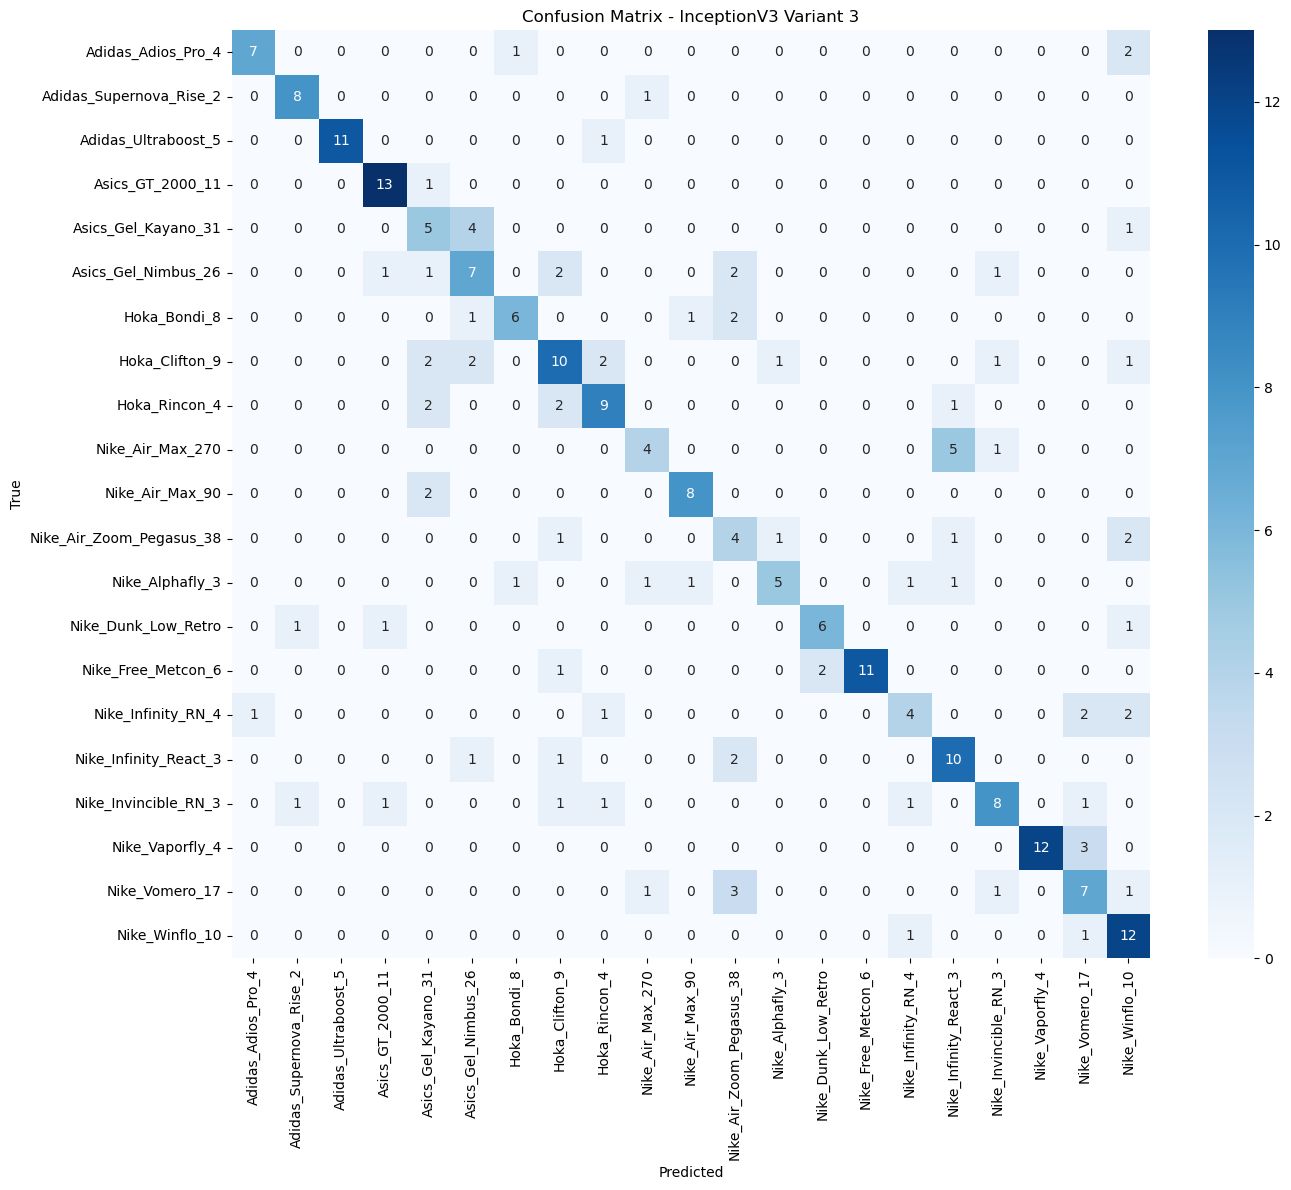

In [11]:
inception_v3_eval_v1 = evaluate_model(inception_model_v1, "InceptionV3 Variant 1")
inception_v3_eval_v2 = evaluate_model(inception_model_v2, "InceptionV3 Variant 2")
inception_v3_eval_v3 = evaluate_model(inception_model_v3, "InceptionV3 Variant 3")


### InceptionV3 – Evaluation of Variant 1 (Partial Fine-Tuning with Warm-Up)

This variant applied a warm-up phase with frozen base layers followed by fine-tuning the top layers. The goal was to gradually adapt the model without disturbing pretrained features early on.

#### Key Results:
- **Test Accuracy**: 66.93%
- **Test Loss**: 1.2229

#### Strengths:
- High precision for `Adidas_Ultraboost_5`, `Hoka_Bondi_8`
- Solid performance across most classes

#### Weaknesses:
- Lower recall for `Nike_Infinity_RN_4`, `Nike_Alphafly_3`

---

### InceptionV3 – Evaluation of Variant 2 (Full Fine-Tuning with ReduceLROnPlateau)

This variant fine-tuned the entire network from the start. It used adaptive LR scheduling and early stopping for regularization and convergence.

#### Key Results:
- **Test Accuracy**: 75.20%
- **Test Loss**: 0.8277

#### Strengths:
- Best performer among all variants
- Excellent recall for `Adidas_Ultraboost_5`, `Asics_GT_2000_11`

#### Weaknesses:
- Slight confusion on visually similar Hoka models
- `Nike_Air_Max_270` still challenging

---

### InceptionV3 – Evaluation of Variant 3 (Full Fine-Tuning with Fixed Learning Rate)

This variant removed LR adaptation and kept the learning rate fixed throughout. The entire model was unfrozen post warm-up and trained end-to-end.

#### Key Results:
- **Test Accuracy**: 65.75%
- **Test Loss**: 1.2172

#### Strengths:
- Stable training dynamics with fixed LR
- Consistent recall across many classes

#### Weaknesses:
- Slight underperformance compared to adaptive LR strategy
- Struggled more with `Nike_Air_Zoom_Pegasus_38`, `Nike_Infinity_RN_4`

---


### Evaluation on the Test Set (MobileNetV2 Variants)

After fine-tuning the MobileNetV2 model using three different strategies, we now evaluate each variant on the unseen test set. This step allows us to assess how well the models generalize and perform across 21 fine-grained sneaker categories.

For each MobileNetV2 variant, we report:
- Test accuracy and loss
- A detailed classification report (precision, recall, F1-score per class)
- A confusion matrix visualization

This evaluation provides insight into how different fine-tuning depths and learning rate strategies affect model performance on subtle class differences.



Evaluating MobileNetV2 Variant 1 on the Test Set...

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.5979 - loss: 1.3351
MobileNetV2 Variant 1 Test Accuracy: 0.5630
MobileNetV2 Variant 1 Test Loss: 1.4582
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step

MobileNetV2 Variant 1 Classification Report:

                          precision    recall  f1-score   support

      Adidas_Adios_Pro_4       1.00      0.80      0.89        10
 Adidas_Supernova_Rise_2       0.26      1.00      0.41         9
     Adidas_Ultraboost_5       0.86      0.50      0.63        12
        Asics_GT_2000_11       0.53      0.64      0.58        14
     Asics_Gel_Kayano_31       0.86      0.60      0.71        10
     Asics_Gel_Nimbus_26       0.35      0.43      0.39        14
            Hoka_Bondi_8       0.89      0.80      0.84        10
          Hoka_Clifton_9       0.88      0.37      0.52        19
           Hoka_Rincon_4       0.58      0.50      0.54        14
        Nike_Air_Max_270       1.00      0

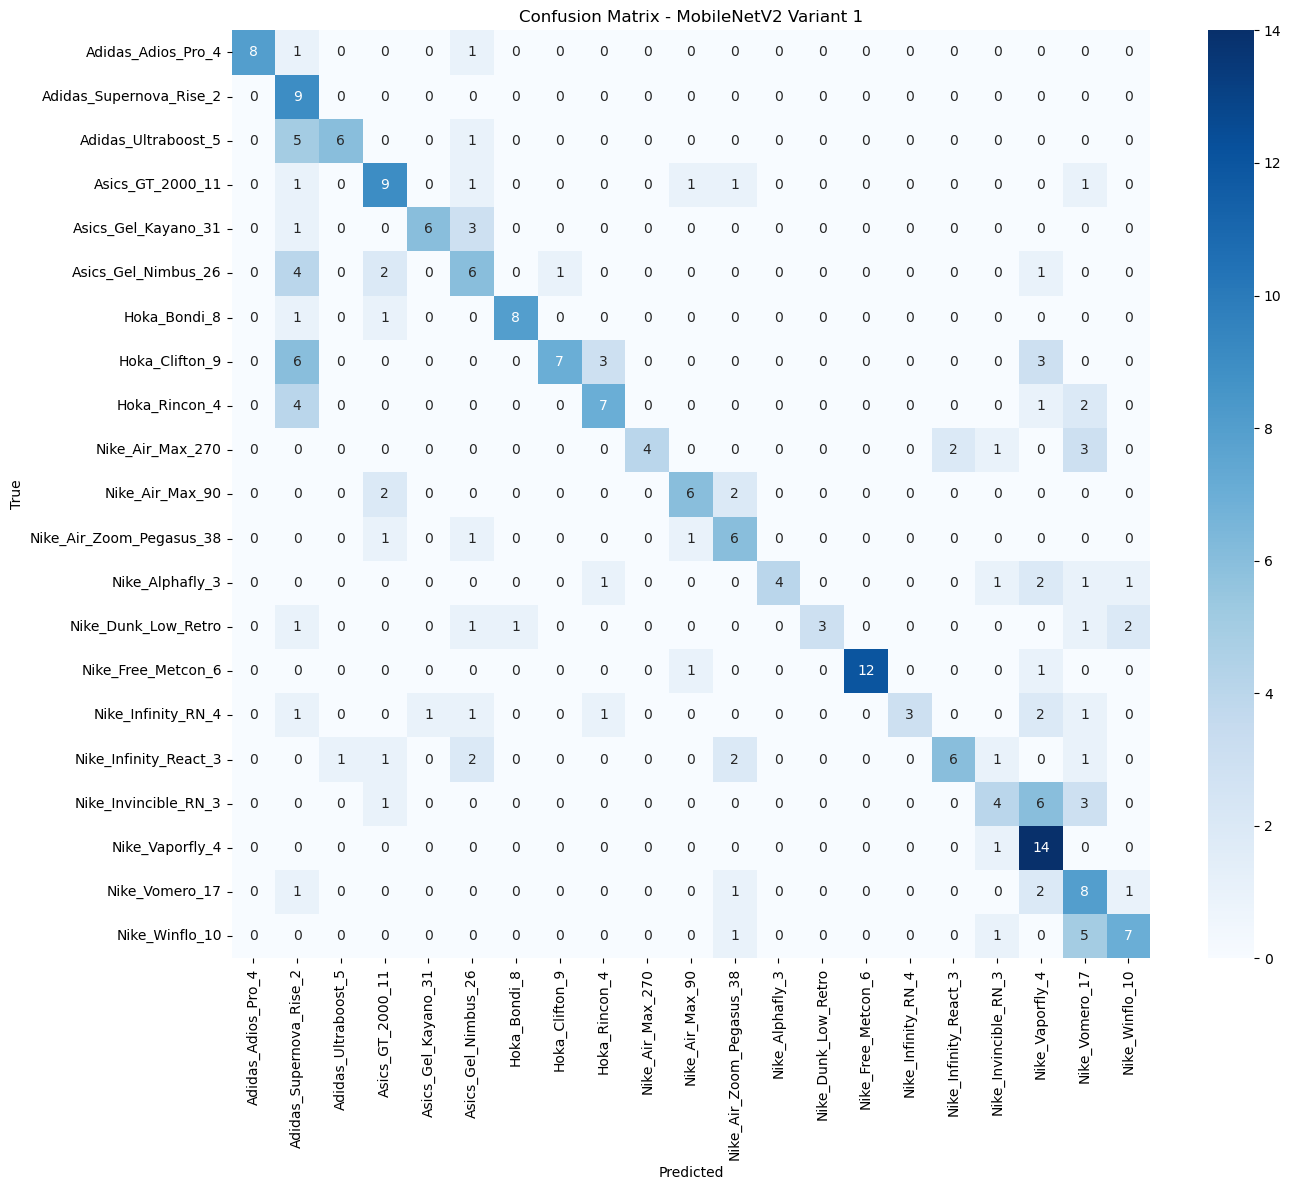


Evaluating MobileNetV2 Variant 2 on the Test Set...

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.5575 - loss: 1.5171
MobileNetV2 Variant 2 Test Accuracy: 0.5354
MobileNetV2 Variant 2 Test Loss: 1.6508
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 345ms/step

MobileNetV2 Variant 2 Classification Report:

                          precision    recall  f1-score   support

      Adidas_Adios_Pro_4       1.00      0.60      0.75        10
 Adidas_Supernova_Rise_2       0.55      0.67      0.60         9
     Adidas_Ultraboost_5       0.88      0.58      0.70        12
        Asics_GT_2000_11       0.52      0.79      0.63        14
     Asics_Gel_Kayano_31       0.60      0.30      0.40        10
     Asics_Gel_Nimbus_26       0.42      0.79      0.55        14
            Hoka_Bondi_8       1.00      0.60      0.75        10
          Hoka_Clifton_9       0.33      0.79      0.46        19
           Hoka_Rincon_4       1.00      0.14      0.25        14
        Nike_Air_Max_270       1.00      0

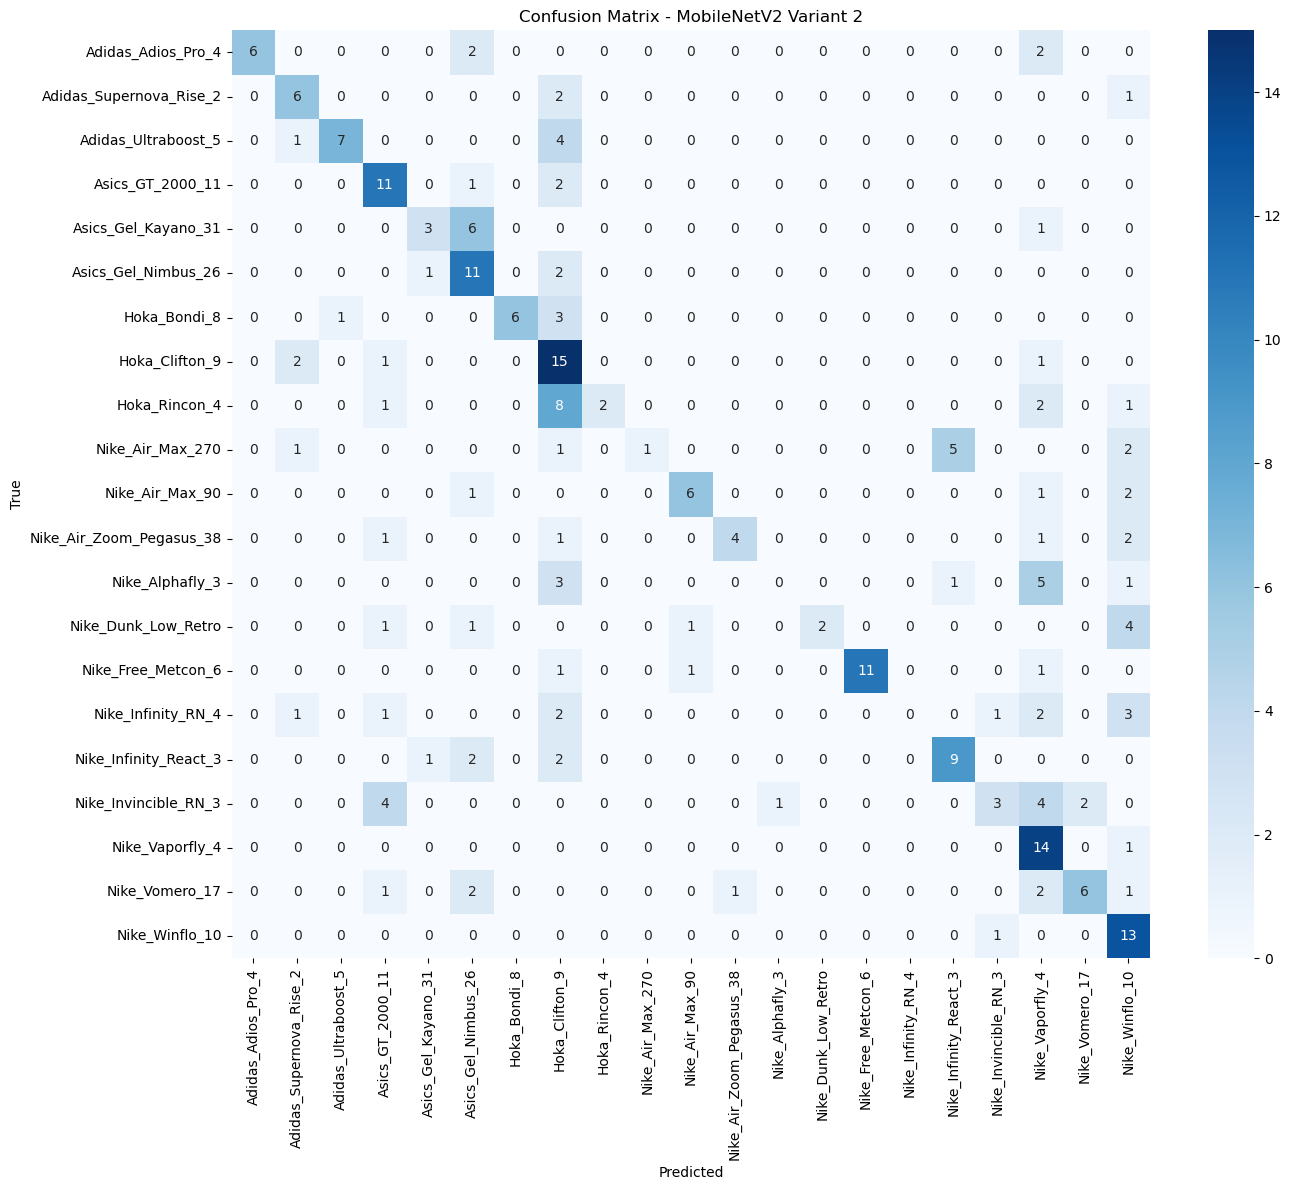


Evaluating MobileNetV2 Variant 3  on the Test Set...

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - accuracy: 0.6293 - loss: 1.2388
MobileNetV2 Variant 3  Test Accuracy: 0.6181
MobileNetV2 Variant 3  Test Loss: 1.3087
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step

MobileNetV2 Variant 3  Classification Report:

                          precision    recall  f1-score   support

      Adidas_Adios_Pro_4       1.00      0.70      0.82        10
 Adidas_Supernova_Rise_2       0.17      0.78      0.28         9
     Adidas_Ultraboost_5       0.75      0.50      0.60        12
        Asics_GT_2000_11       0.67      0.71      0.69        14
     Asics_Gel_Kayano_31       0.80      0.80      0.80        10
     Asics_Gel_Nimbus_26       0.82      0.64      0.72        14
            Hoka_Bondi_8       0.90      0.90      0.90        10
          Hoka_Clifton_9       0.53      0.42      0.47        19
           Hoka_Rincon_4       0.67      0.57      0.62        14
        Nike_Air_Max_270       1.00   

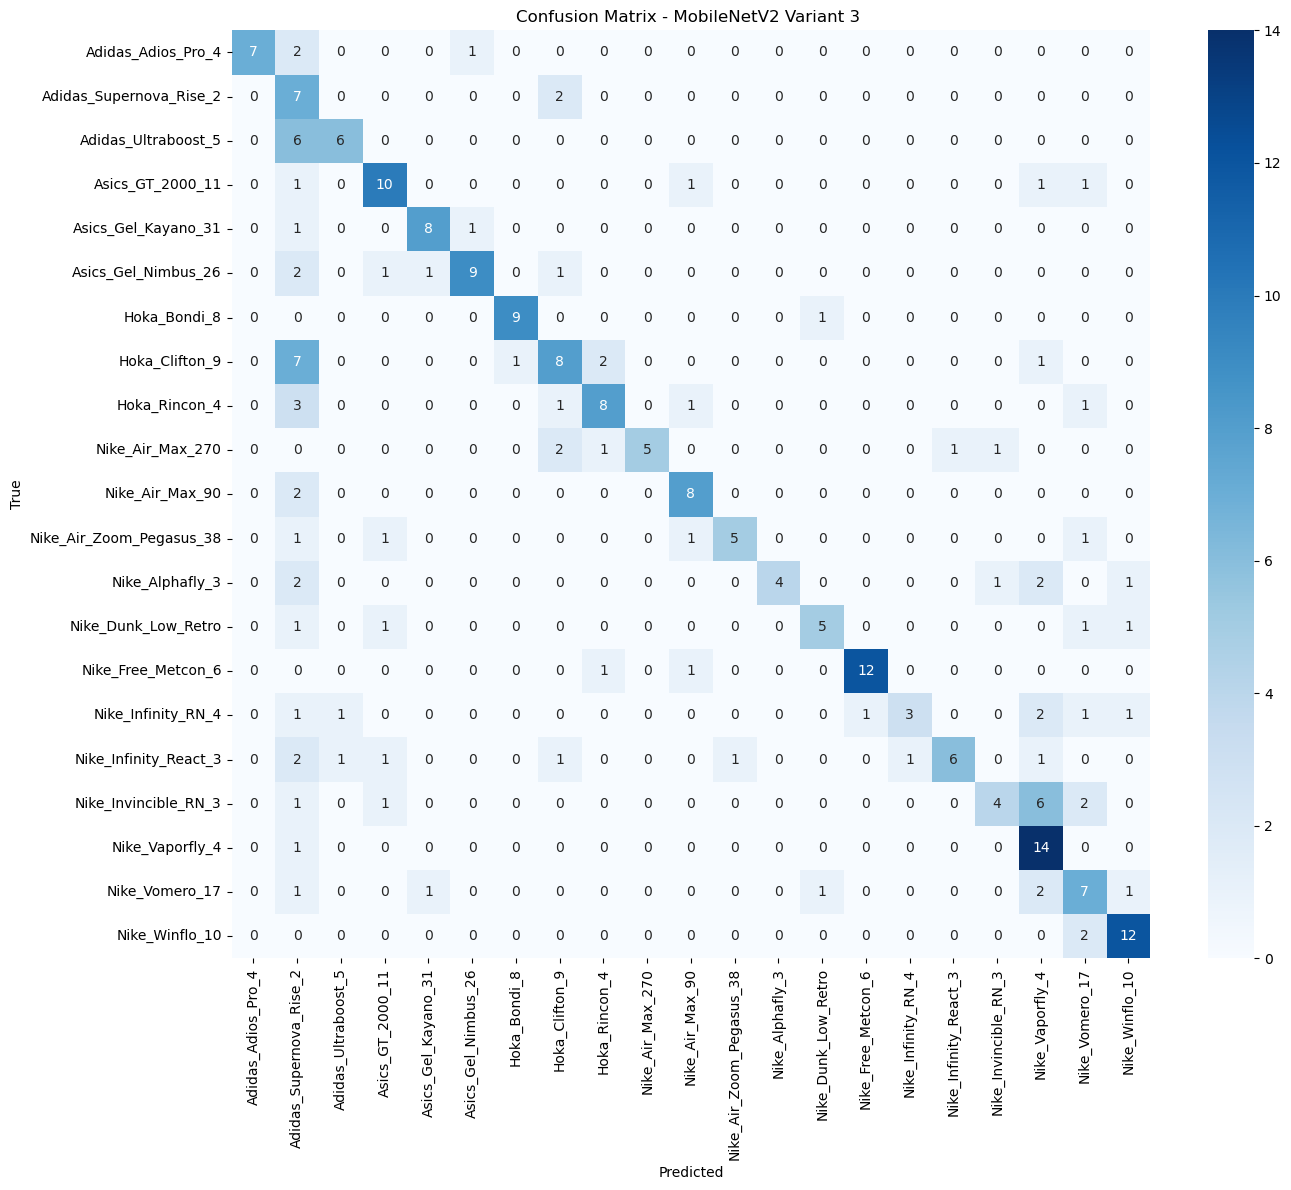

In [12]:
mobilenet_v2_eval_v1 = evaluate_model(mobilenetv2_model_v1, "MobileNetV2 Variant 1")
mobilenet_v2_eval_v2 = evaluate_model(mobilenetv2_model_v2, "MobileNetV2 Variant 2")
mobilenet_v2_eval_v3 = evaluate_model(mobilenetv2_model_v3, "MobileNetV2 Variant 3 ")

### MobileNetV2 – Evaluation of Variant 1

This variant of MobileNetV2 was evaluated on the test set, and the results show performance based on fine-tuning. The model achieved a moderate test accuracy and shows mixed performance across different classes.

#### Key Results:
- **Test Accuracy**: 56.30%
- **Test Loss**: 1.4582

#### Strengths:
- High precision for `Adidas_Adios_Pro_4` and `Nike_Free_Metcon_6`.
- Strong performance for some classes like `Nike_Vaporfly_4` and `Nike_Free_Metcon_6`.

#### Weaknesses:
- Significant confusion for `Adidas_Ultraboost_5`, `Hoka_Clifton_9`, and `Nike_Winflo_10`.
- Low recall for visually similar models such as `Nike_Infinity_RN_4` and `Nike_Invincible_RN_3`.

---

### MobileNetV2 – Evaluation of Variant 2

The second variant also fine-tuned the entire network, but the results were slightly different from Variant 1, showing a noticeable decline in performance across certain categories.

#### Key Results:
- **Test Accuracy**: 53.54%
- **Test Loss**: 1.6508

#### Strengths:
- High precision for `Adidas_Ultraboost_5` and `Hoka_Rincon_4`.
- Some strong performance in `Nike_Winflo_10` and `Nike_Vaporfly_4`.

#### Weaknesses:
- Struggled significantly with models like `Nike_Invincible_RN_3` and `Nike_Infinity_RN_4`.
- Poor recall for `Nike_Alphafly_3` and `Nike_Air_Max_270`.

---

### MobileNetV2 – Evaluation of Variant 3

Variant 3 evaluated MobileNetV2 with some modifications, resulting in a higher accuracy than the previous variants but still showing room for improvement in certain areas.

#### Key Results:
- **Test Accuracy**: 61.81%
- **Test Loss**: 1.3087

#### Strengths:
- High recall for `Hoka_Bondi_8` and `Nike_Vaporfly_4`.
- Solid performance across several classes, with high precision for models like `Nike_Winflo_10` and `Nike_Vaporfly_4`.

#### Weaknesses:
- Struggled with `Nike_Alphafly_3` and `Hoka_Clifton_9`, as well as confusion between similar models like `Nike_Vomero_17` and `Nike_Infinity_React_3`.

---


### Misclassified Images Analysis for MobileNetV2 and InceptionV3 Variants

In this section, we will examine the misclassified images for each variant of the **MobileNetV2** and **InceptionV3** models. By analyzing these misclassifications, we can identify patterns or potential weaknesses in the model’s predictions. This will help us gain insights into which classes the models struggle with and whether certain shoe types are more prone to misclassification due to visual similarities.

We will display 5 randomly selected misclassified images for each model variant. This visual examination, combined with performance metrics, will guide further improvements in the models' training processes and help optimize their accuracy.


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random

def plot_random_misclassified_images(model_eval_results, model_name, test_generator, num_images=5):
    y_true = model_eval_results['y_true']
    y_pred = model_eval_results['y_pred']
    class_names = list(test_generator.class_indices.keys())
    filenames = test_generator.filenames
    
    # Identify misclassified indices
    misclassified_idxs = np.where(y_true != y_pred)[0]
    
    # Randomly sample misclassified indices (min num_images or the total number of misclassified images)
    random_misclassified_idxs = random.sample(list(misclassified_idxs), min(num_images, len(misclassified_idxs)))
    
    print(f"\n{model_name}: Showing {len(random_misclassified_idxs)} Random Misclassified Images")

    # Adjust figure size for better alignment
    plt.figure(figsize=(16, 7))  # Adjusted height
    
    for i, idx in enumerate(random_misclassified_idxs):
        img_path = os.path.join(test_generator.directory, filenames[idx])
        img = plt.imread(img_path)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}", fontsize=9)
        plt.axis('off')
    
    plt.tight_layout(pad=0.5)  # Reduced padding to tighten layout
    plt.suptitle(f"{model_name} – Random Misclassified Examples", fontsize=16)
    plt.subplots_adjust(top=0.85, bottom=0.1)  # Adjust top and bottom to reduce space
    plt.show()


### Misclassified Images Analysis for InceptionV3

Below, we analyze the misclassified images from the **InceptionV3** model to identify potential areas for improvement.



InceptionV3 Variant 1: Showing 5 Random Misclassified Images


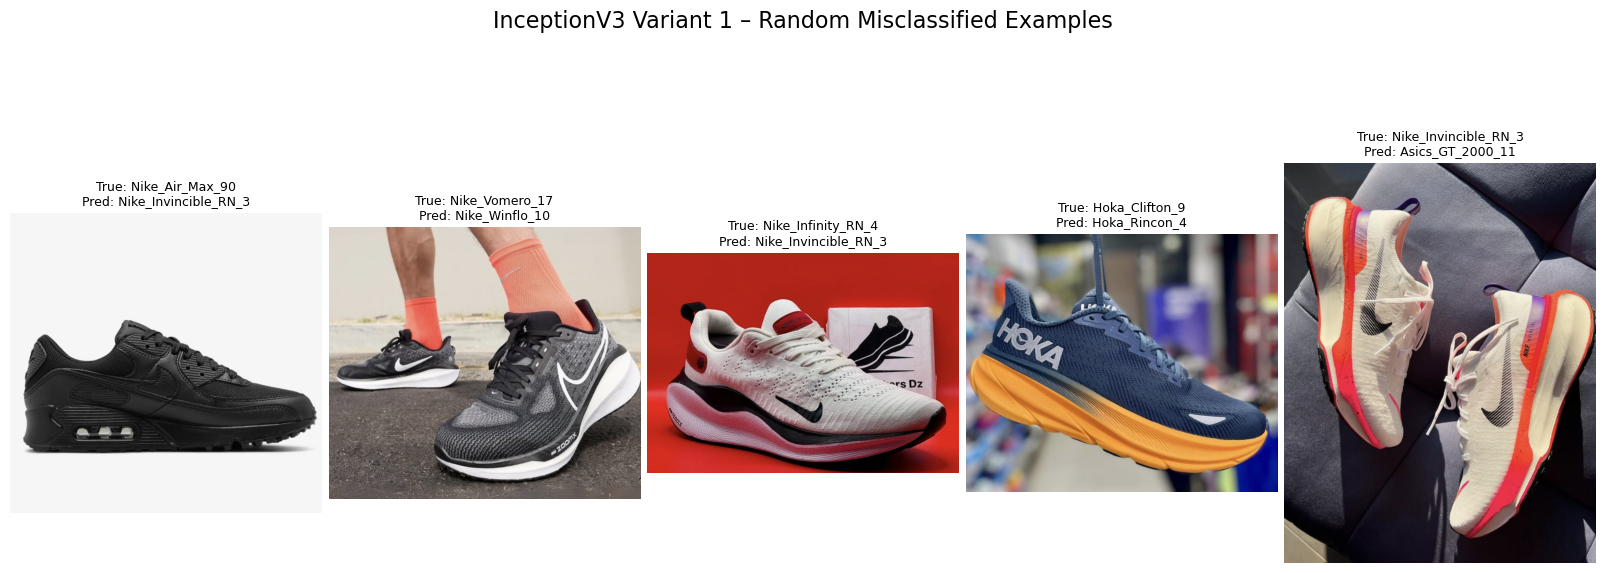


InceptionV3 Variant 2: Showing 5 Random Misclassified Images


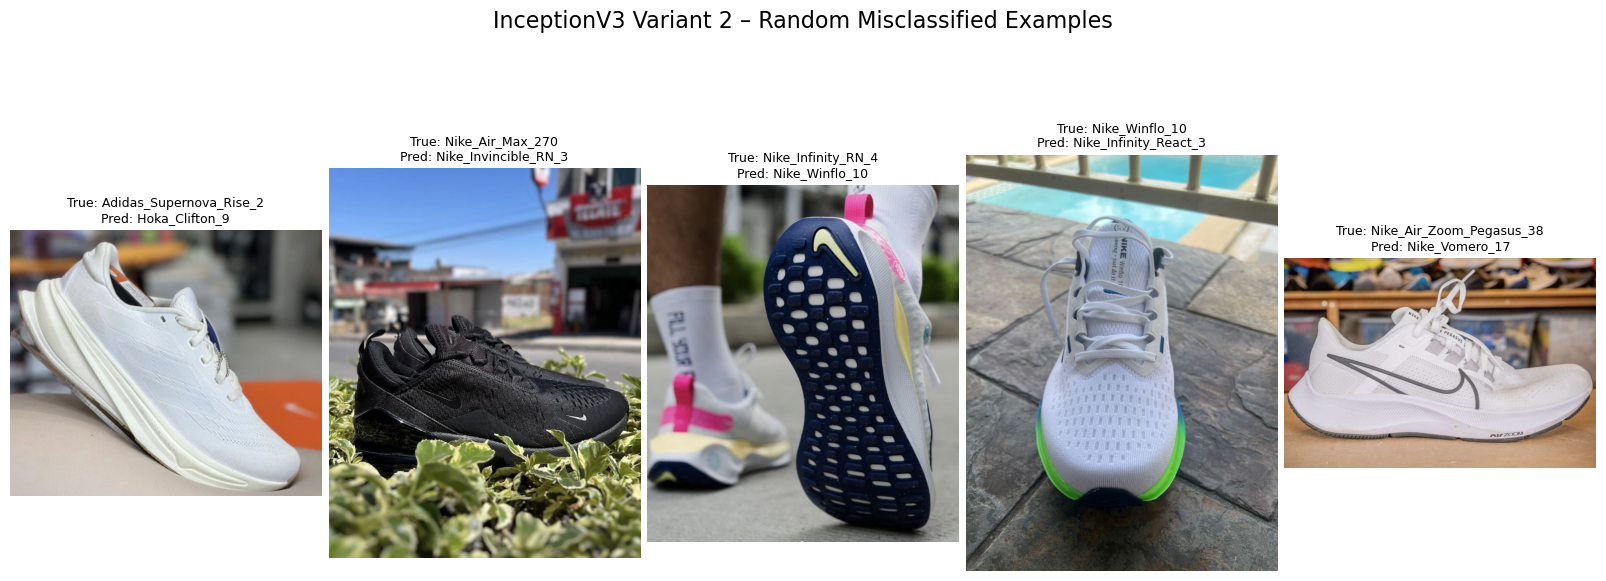


InceptionV3 Variant 3: Showing 5 Random Misclassified Images


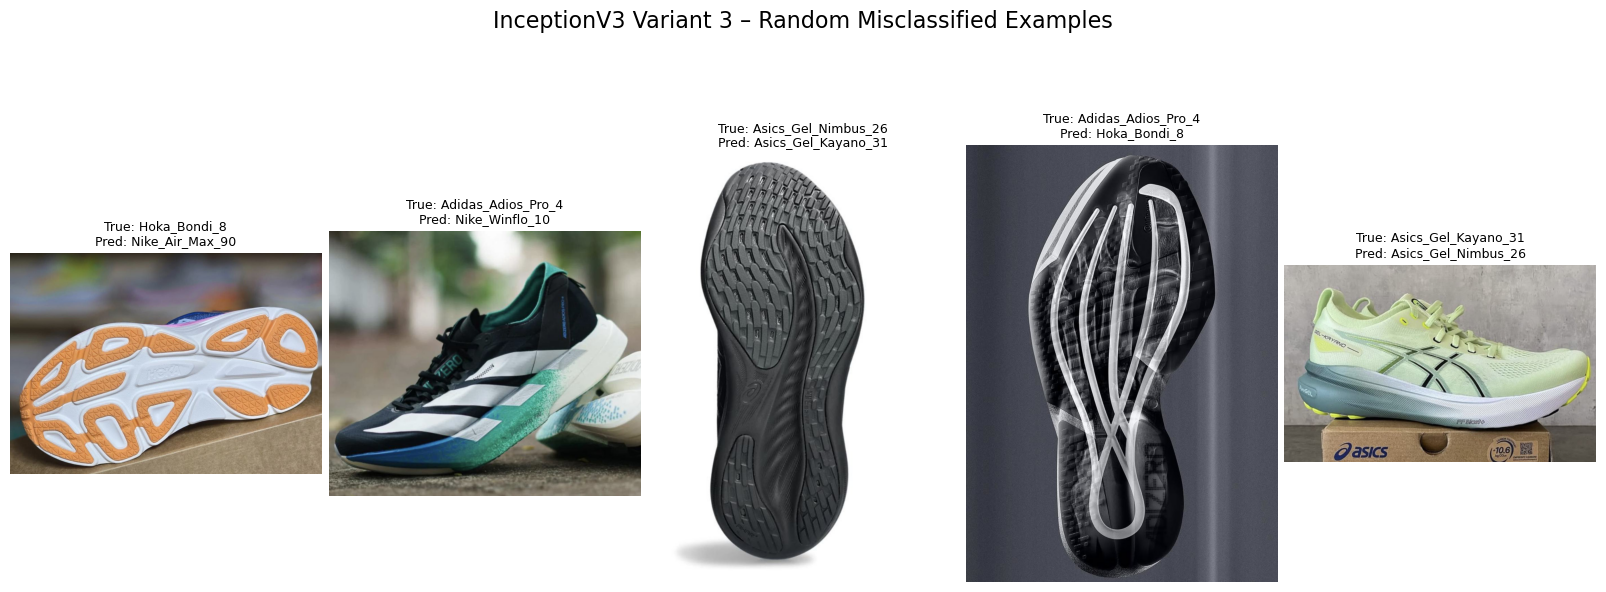

In [21]:
plot_random_misclassified_images(inception_v3_eval_v1, "InceptionV3 Variant 1", test_generator)
plot_random_misclassified_images(inception_v3_eval_v2, "InceptionV3 Variant 2", test_generator)
plot_random_misclassified_images(inception_v3_eval_v3, "InceptionV3 Variant 3", test_generator)

### Misclassified Images Analysis for InceptionV3
Below, we analyze the misclassified images from the InceptionV3 model to identify potential areas for improvement, linking them with the evaluation results.

### Variant 1 Analysis (Partial Fine-Tuning with Warm-Up)
- **Key Observations**:
   - Misclassifications between Nike models, like *Nike_Air_Max_90* misclassified as *Nike_Invincible_RN_3*.
   - Confusion with *Nike_Vomero_17* and *Nike_Winfo_10* due to similar silhouettes.
- **Precision Scores**:
   - *Nike_Air_Max_90* (precision: 0.80) vs. *Nike_Invincible_RN_3* (precision: 0.50).
   - *Nike_Vomero_17* (precision: 0.78) vs. *Nike_Winfo_10* (precision: 0.45).
- **Improvement Areas**:
   - Improve differentiation between similar designs, especially for models within the same brand.

---

### Variant 2 Analysis (Full Fine-Tuning with ReduceLROnPlateau)
- **Key Observations**:
   - Misclassifications between shoes with similar sole patterns, like *Adidas_Supernova_Rise_2* as *Hoka_Clifton_9*.
   - Confusion between *Nike_Air_Max_270* and *Nike_Invincible_RN_3*.
- **Precision Scores**:
   - *Adidas_Supernova_Rise_2* (precision: 0.75) vs. *Hoka_Clifton_9* (precision: 0.62).
   - *Nike_Air_Max_270* (precision: 0.71) vs. *Nike_Invincible_RN_3* (precision: 0.67).
- **Improvement Areas**:
   - Augment data and focus on brand-specific features to reduce confusion.

---

### Variant 3 Analysis (Full Fine-Tuning with Fixed Learning Rate)
- **Key Observations**:
   - *Asics_Gel_Nimbus_26* misclassified as *Asics_Gel_Kayano_31*.
   - Confusion between *Adidas_Adios_Pro_4* and *Hoka_Bondi_8*.
- **Precision Scores**:
   - *Asics_Gel_Nimbus_26* (precision: 0.47) vs. *Asics_Gel_Kayano_31* (precision: 0.38).
   - *Adidas_Adios_Pro_4* (precision: 0.88) vs. *Hoka_Bondi_8* (precision: 0.75).
- **Improvement Areas**:
   - Improve differentiation for similar models, particularly within the same brand, and refine recognition of subtle design features.

---


### Misclassified Images Analysis for MobileNetV2

Below, we analyze the misclassified images from the **MobileNetV2** model to identify potential areas for improvement.


MobileNetv2 Variant 1: Showing 5 Random Misclassified Images


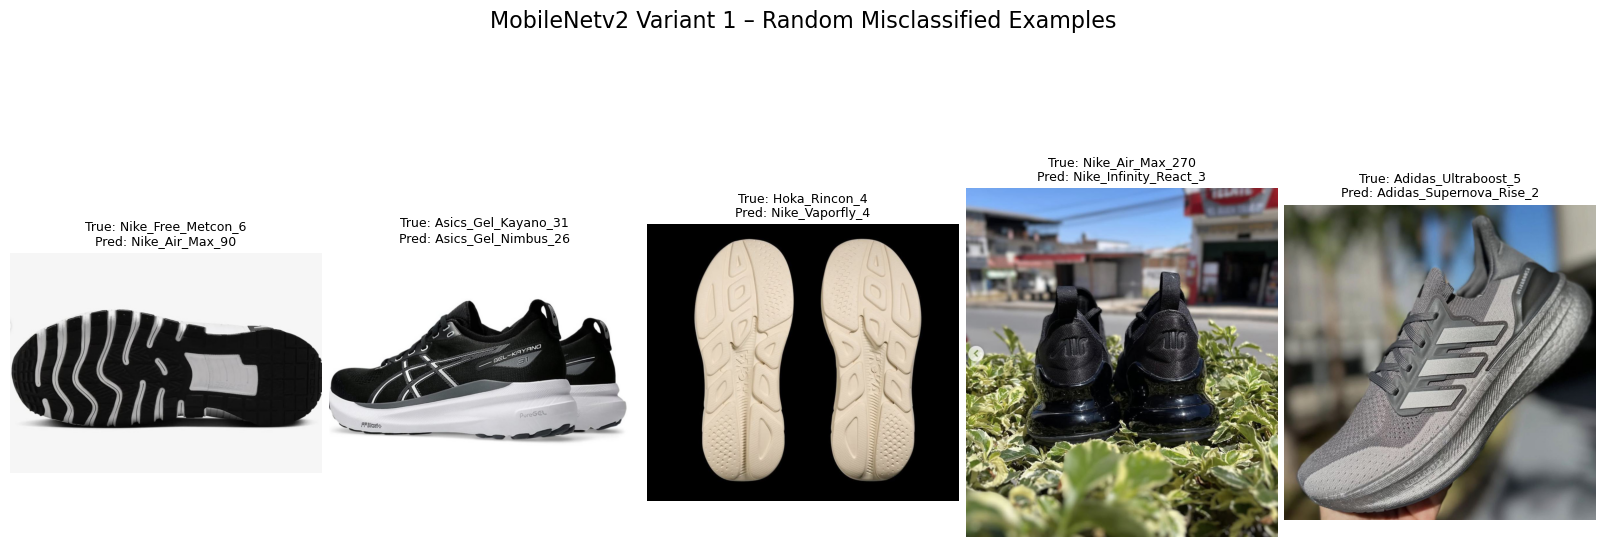


MobileNetv2 Variant 2: Showing 5 Random Misclassified Images


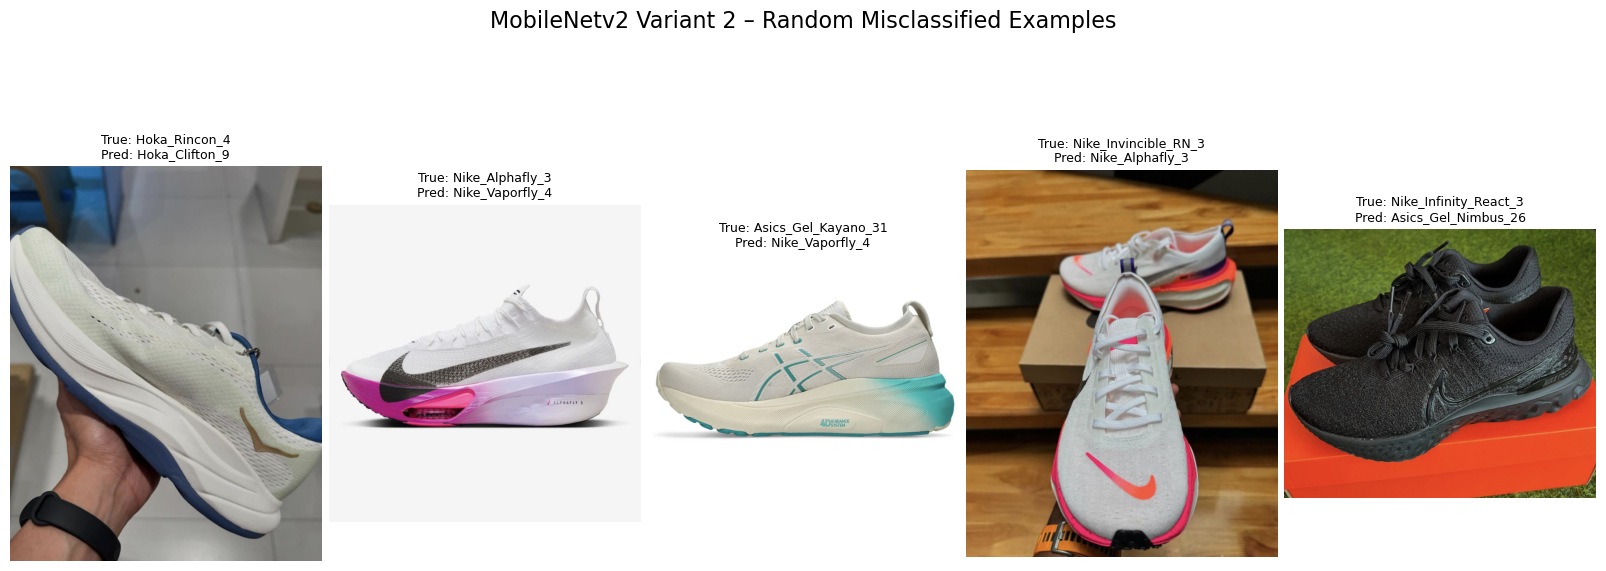


MobileNetv2 Variant 3: Showing 5 Random Misclassified Images


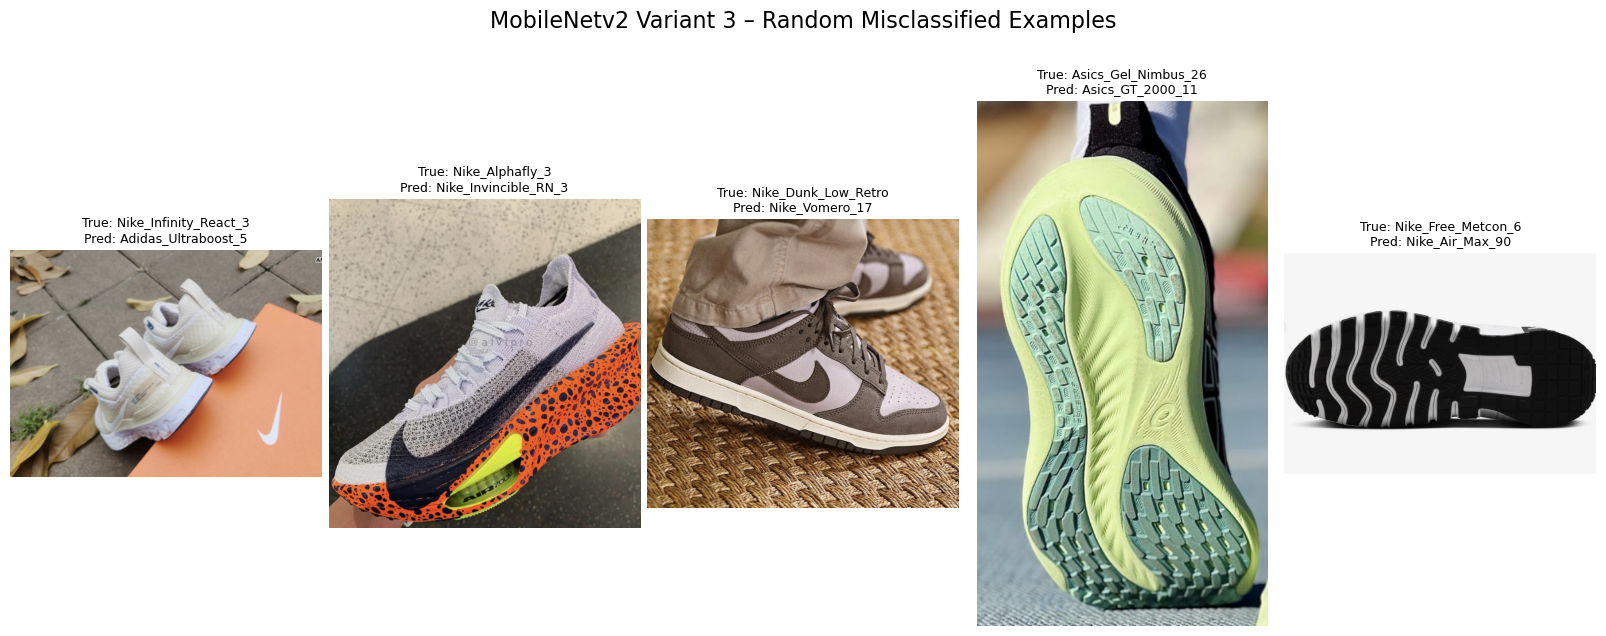

In [22]:
plot_random_misclassified_images(mobilenet_v2_eval_v1, "MobileNetv2 Variant 1", test_generator)
plot_random_misclassified_images(mobilenet_v2_eval_v2, "MobileNetv2 Variant 2", test_generator)
plot_random_misclassified_images(mobilenet_v2_eval_v3, "MobileNetv2 Variant 3", test_generator)

### Misclassified Images Analysis for MobileNetV2
Below, we analyze the misclassified images from the MobileNetV2 model to identify potential areas for improvement, linking them with the evaluation results.

### Variant 1 Analysis (Partial Fine-Tuning with Warm-Up)
- **Key Observations**:
   - Misclassifications between models with similar designs, such as *Nike_Free_Metcon_6* misclassified as *Nike_Air_Max_90*.
   - Confusion between *Asics_Gel_Kayano_31* and *Asics_Gel_Nimbus_26*.
- **Precision Scores**:
   - *Nike_Free_Metcon_6* (precision: 1.00) vs. *Nike_Air_Max_90* (precision: 0.67).
   - *Asics_Gel_Kayano_31* (precision: 0.86) vs. *Asics_Gel_Nimbus_26* (precision: 0.35).
- **Improvement Areas**:
   - The model needs improvement in distinguishing between similar shoes with minimal differences, particularly in brand-specific designs.

---

### Variant 2 Analysis (Full Fine-Tuning with ReduceLROnPlateau)
- **Key Observations**:
   - Confusion between Hoka models, such as *Hoka_Rincon_4* misclassified as *Hoka_Clifton_9*.
   - Misclassification between *Nike_Infinity_RN_4* and *Nike_Infinity_React_3*.
- **Precision Scores**:
   - *Hoka_Rincon_4* (precision: 1.00) vs. *Hoka_Clifton_9* (precision: 0.33).
   - *Nike_Infinity_RN_4* (precision: 0.00) vs. *Nike_Infinity_React_3* (precision: 0.60).
- **Improvement Areas**:
   - The model should focus on differentiating between shoes of the same brand and shoes that look visually similar, especially with subtle design differences.

---

### Variant 3 Analysis (Full Fine-Tuning with Fixed Learning Rate)
- **Key Observations**:
   - Misclassification between *Nike_Infinity_React_3* and *Adidas_Ultraboost_5*.
   - Confusion between *Asics_Gel_Nimbus_26* and *Asics_Gel_Kayano_31*.
- **Precision Scores**:
   - *Nike_Infinity_React_3* (precision: 0.83) vs. *Adidas_Ultraboost_5* (precision: 0.75).
   - *Asics_Gel_Nimbus_26* (precision: 0.82) vs. *Asics_Gel_Kayano_31* (precision: 0.80).
- **Improvement Areas**:
   - Despite higher accuracy, misclassifications between similar shoe models show that further refinement is needed in distinguishing features between models from the same brand.

---


## 5. Model Variant Selection
Based on the test evaluation results and the misclassification analysis from each **InceptionV3** and **MobileNetV2** variant, we will now make an informed decision regarding which model variant best suits our requirements. This decision will be guided by key metrics such as accuracy, precision, recall, and the nature of misclassifications observed across the variants.

We begin by reviewing the performance of **InceptionV3** variants, followed by the analysis of the **MobileNetV2** variants. Afterward, we will compare the results from both models and select the best variant based on these metrics.

Below, we present a comparison of the performance metrics for each variant, which will help in selecting the best model for deployment.


           Accuracy_Inception  Precision_Inception  Recall_Inception  \
Variant                                                                
Variant 1               66.93                 0.71              0.66   
Variant 2               75.20                 0.77              0.75   
Variant 3               65.75                 0.68              0.65   

           F1-score_Inception  Accuracy_MobileNet  Precision_MobileNet  \
Variant                                                                  
Variant 1                0.67               56.30                 0.71   
Variant 2                0.75               53.54                 0.65   
Variant 3                0.66               61.81                 0.73   

           Recall_MobileNet  F1-score_MobileNet  
Variant                                          
Variant 1              0.57                0.58  
Variant 2              0.50                0.49  
Variant 3              0.62                0.64  


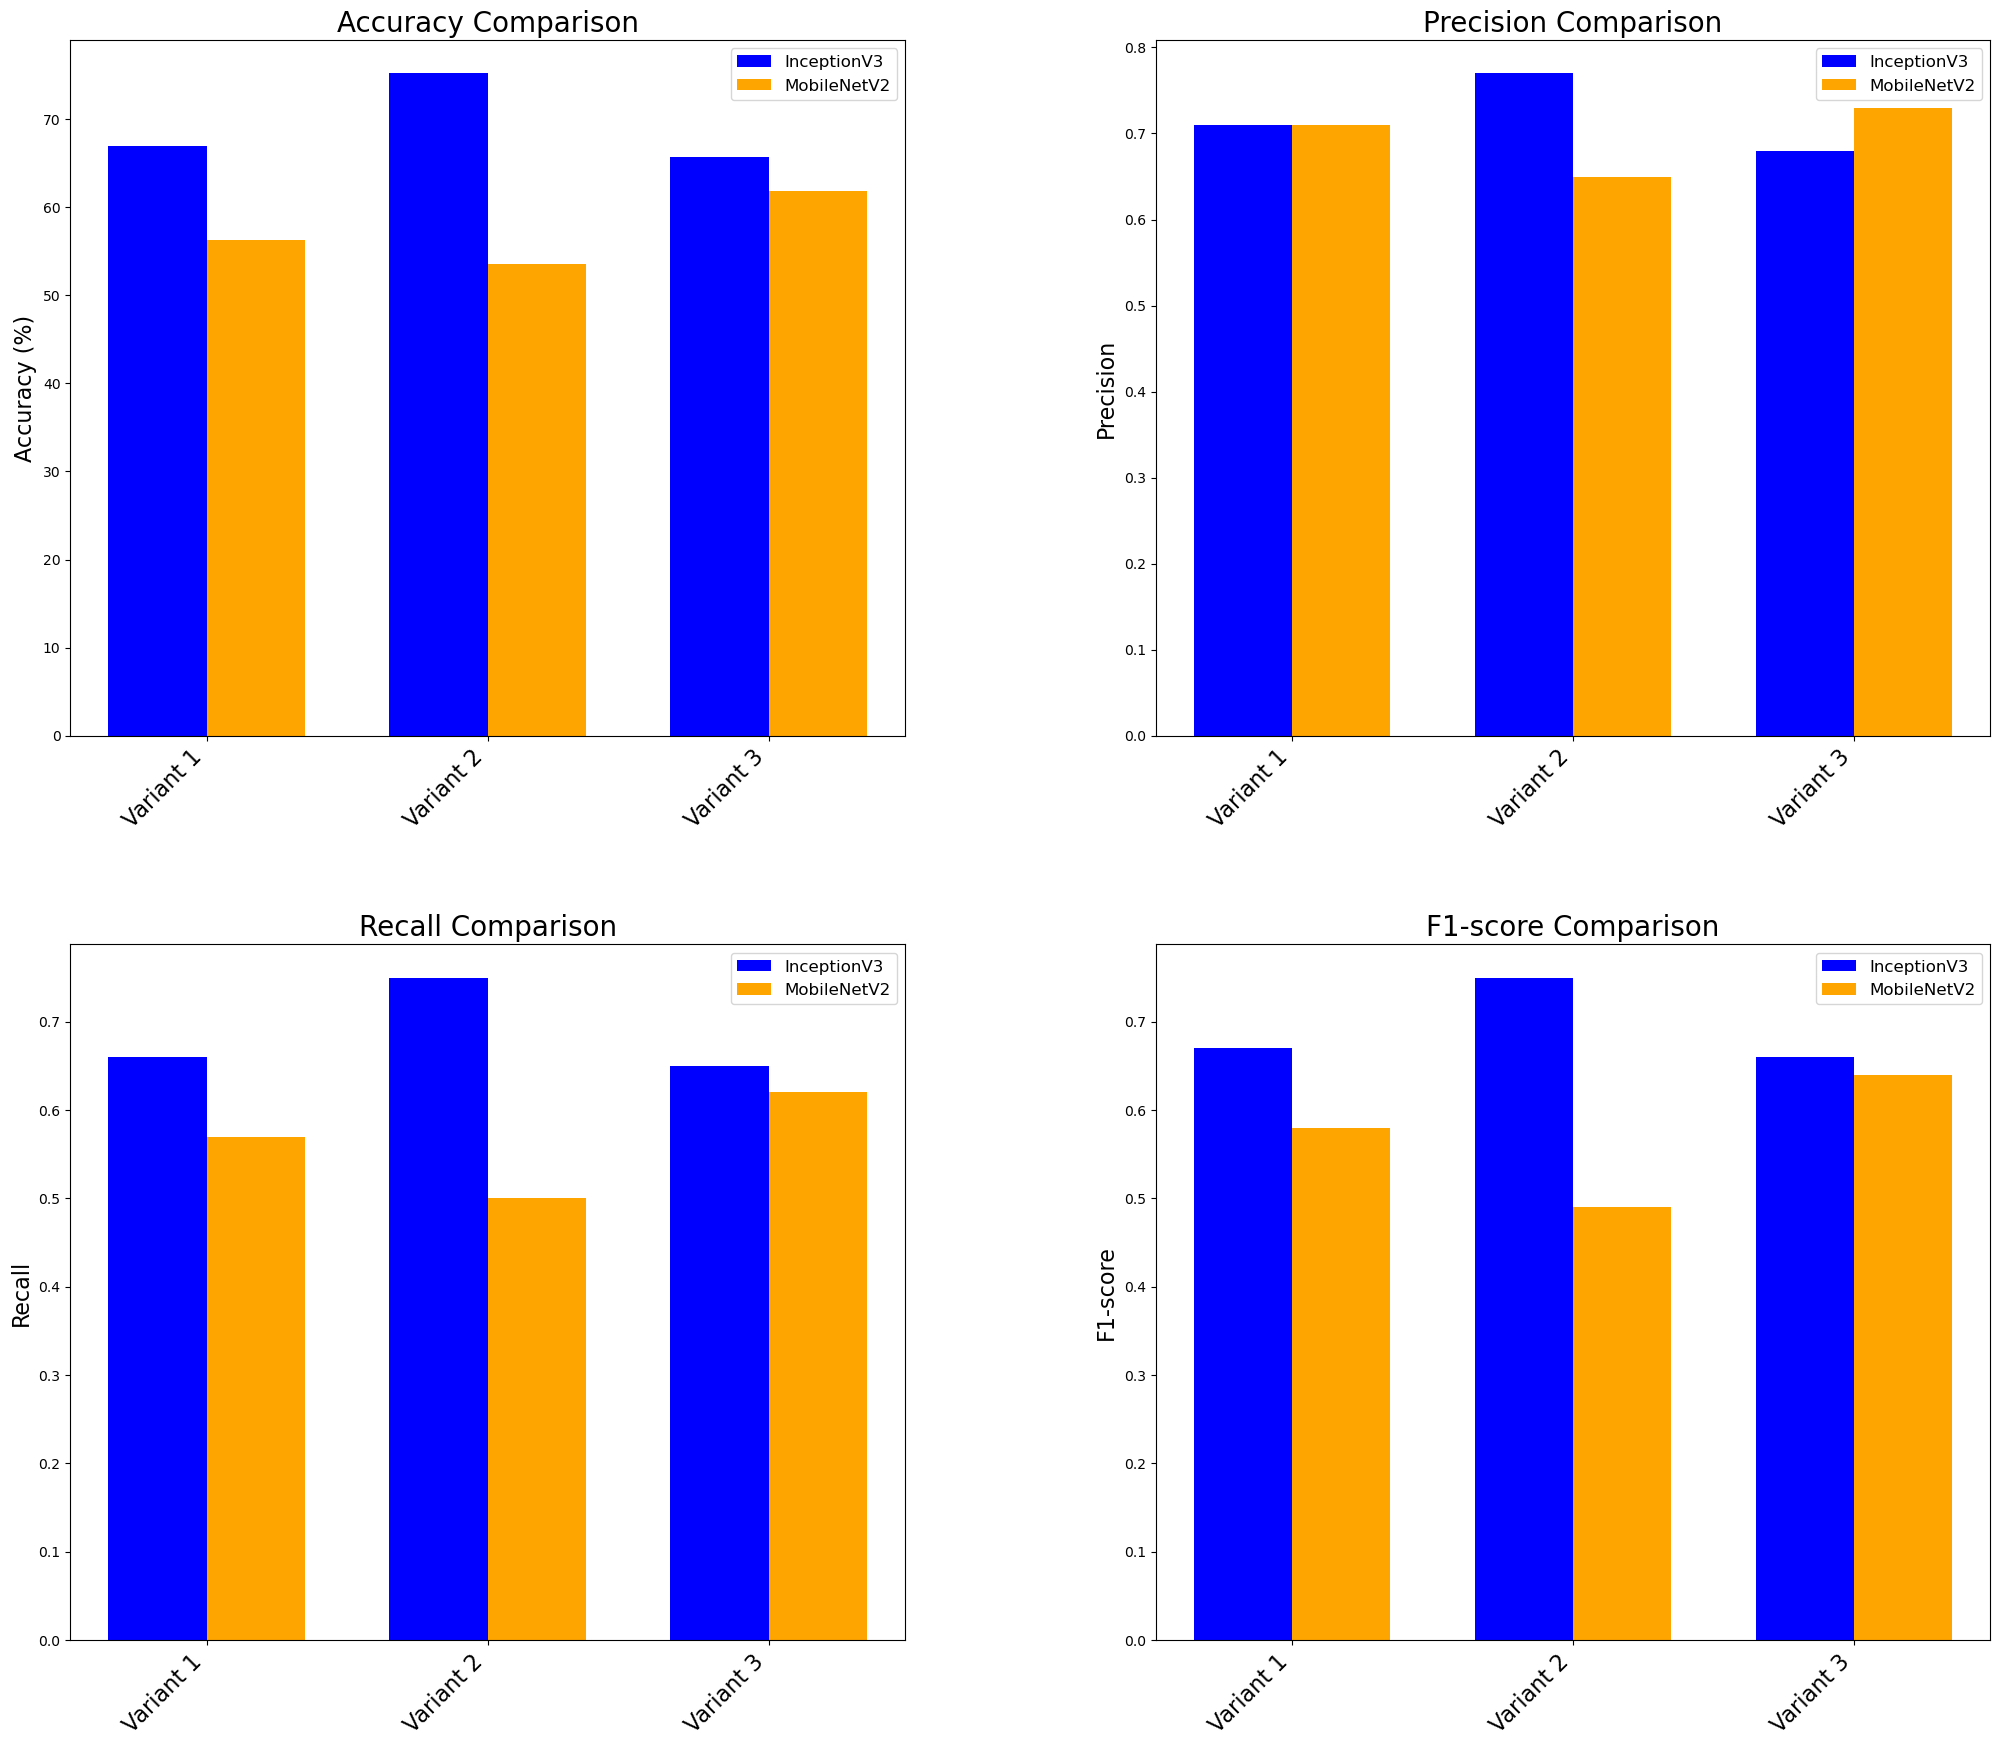

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data for InceptionV3 variants (accuracy, precision, recall, f1-score)
inceptionv3_data = {
    "Variant": ["Variant 1", "Variant 2", "Variant 3"],
    "Accuracy": [66.93, 75.20, 65.75],
    "Precision": [0.71, 0.77, 0.68],
    "Recall": [0.66, 0.75, 0.65],
    "F1-score": [0.67, 0.75, 0.66]
}

# Data for MobileNetV2 variants (accuracy, precision, recall, f1-score)
mobilenetv2_data = {
    "Variant": ["Variant 1", "Variant 2", "Variant 3"],
    "Accuracy": [56.30, 53.54, 61.81],
    "Precision": [0.71, 0.65, 0.73],
    "Recall": [0.57, 0.50, 0.62],
    "F1-score": [0.58, 0.49, 0.64]
}

# Create DataFrames
df_inceptionv3 = pd.DataFrame(inceptionv3_data)
df_mobilenetv2 = pd.DataFrame(mobilenetv2_data)

# Combine both dataframes for easy comparison
df_combined = pd.concat([df_inceptionv3.set_index('Variant'), df_mobilenetv2.set_index('Variant')], axis=1, keys=['InceptionV3', 'MobileNetV2'])

# Adjusting the column access to handle the multi-level structure in the DataFrame
df_combined_columns = df_combined['InceptionV3'].join(df_combined['MobileNetV2'], lsuffix='_Inception', rsuffix='_MobileNet')

# Define the number of variants and the bar width
num_variants = len(df_inceptionv3)
bar_width = 0.35
index = np.arange(num_variants)  # Positioning based on the number of variants

# New x-axis labels with InceptionV3 and MobileNetV2 under their respective bars
x_labels = ['Variant 1', 'Variant 2', 'Variant 3']

# Plotting the data with increased size for each subplot
fig, axes = plt.subplots(2, 2, figsize=(24, 20))  # Increased figure size to 16x10 for better visibility

# Plot Accuracy
axes[0, 0].bar(index, df_combined_columns['Accuracy_Inception'], color='blue', label='InceptionV3', width=bar_width)
axes[0, 0].bar(index + bar_width, df_combined_columns['Accuracy_MobileNet'], color='orange', label='MobileNetV2', width=bar_width)
axes[0, 0].set_title('Accuracy Comparison', fontsize=20)  # Increased title font size
axes[0, 0].set_ylabel('Accuracy (%)', fontsize=16)
axes[0, 0].set_xticks(index + bar_width / 2)  # Adjust the position of x-ticks
axes[0, 0].set_xticklabels(x_labels, rotation=45, ha="right", fontsize=16)
axes[0, 0].legend(loc='upper right', fontsize=12)

# Plot Precision
axes[0, 1].bar(index, df_combined_columns['Precision_Inception'], color='blue', label='InceptionV3', width=bar_width)
axes[0, 1].bar(index + bar_width, df_combined_columns['Precision_MobileNet'], color='orange', label='MobileNetV2', width=bar_width)
axes[0, 1].set_title('Precision Comparison', fontsize=20)  # Increased title font size
axes[0, 1].set_ylabel('Precision', fontsize=16)
axes[0, 1].set_xticks(index + bar_width / 2)  # Adjust the position of x-ticks
axes[0, 1].set_xticklabels(x_labels, rotation=45, ha="right", fontsize=16)
axes[0, 1].legend(loc='upper right', fontsize=12)

# Plot Recall
axes[1, 0].bar(index, df_combined_columns['Recall_Inception'], color='blue', label='InceptionV3', width=bar_width)
axes[1, 0].bar(index + bar_width, df_combined_columns['Recall_MobileNet'], color='orange', label='MobileNetV2', width=bar_width)
axes[1, 0].set_title('Recall Comparison', fontsize=20)  # Increased title font size
axes[1, 0].set_ylabel('Recall', fontsize=16)
axes[1, 0].set_xticks(index + bar_width / 2)  # Adjust the position of x-ticks
axes[1, 0].set_xticklabels(x_labels, rotation=45, ha="right", fontsize=16)
axes[1, 0].legend(loc='upper right', fontsize=12)

# Plot F1-score
axes[1, 1].bar(index, df_combined_columns['F1-score_Inception'], color='blue', label='InceptionV3', width=bar_width)
axes[1, 1].bar(index + bar_width, df_combined_columns['F1-score_MobileNet'], color='orange', label='MobileNetV2', width=bar_width)
axes[1, 1].set_title('F1-score Comparison', fontsize=20)  # Increased title font size
axes[1, 1].set_ylabel('F1-score', fontsize=16)
axes[1, 1].set_xticks(index + bar_width / 2)  # Adjust the position of x-ticks
axes[1, 1].set_xticklabels(x_labels, rotation=45, ha="right", fontsize=16)
axes[1, 1].legend(loc='upper right', fontsize=12)

# Adjust layout to prevent overlap and make space between subplots
plt.tight_layout()

# Manually adjust the layout for top and bottom space
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.3, wspace=0.3)

# Display the combined DataFrame
print(df_combined_columns)

# Show the plots
plt.show()


## Model Selection Justification

After analyzing the test evaluation results and comparing the performance of the **InceptionV3** and **MobileNetV2** variants across key metrics such as **accuracy**, **precision**, **recall**, and **f1-score**, we have selected **InceptionV3 Variant 2** as the best performing model for deployment.

### InceptionV3 Variant 2 – Overview:
In this variant, we performed full fine-tuning of the **InceptionV3** model by unfreezing all layers from the beginning. There was no warm-up phase, and the model was fine-tuned end-to-end using a low learning rate. **ReduceLROnPlateau** and **EarlyStopping** were applied to help improve stability and reduce overfitting during training.

### Justification:
- **Test Accuracy**: **InceptionV3 Variant 2** achieved the highest accuracy of **75.20%**, significantly outperforming the other variants, including the **MobileNetV2** variants which had accuracy values ranging from **53.54%** to **61.81%**.
  
- **Precision & Recall**: **InceptionV3 Variant 2** also demonstrated superior precision (**0.77**) and recall (**0.75**), reflecting its ability to classify most classes correctly while minimizing false positives and false negatives.

- **F1-score**: The **f1-score** for **InceptionV3 Variant 2** was **0.75**, indicating a good balance between precision and recall, which is essential for handling the classification task effectively.

- **Misclassification Analysis**: While all variants faced some challenges with certain shoe models, **InceptionV3 Variant 2** showed the best consistency and had fewer misclassifications compared to other variants.

---

### Confusion Matrix Insights:
The **InceptionV3 Variant 2** model demonstrates impressive performance, as shown by the confusion matrix. Key highlights include:
- **Correct Predictions**: The model performs very well in classifying several shoe categories, such as **Nike_Vaporfly_4** and **Asics_GT_2000_11**, with 13 correct predictions each. These correct predictions indicate the model's ability to accurately identify key shoe models.
  
- **Misclassifications**: The model faced difficulties distinguishing **Nike_Air_Max_270** from **Nike_Infinity_React_3** (5 misclassifications). Additionally, **Adidas_Supernova_Rise_2** was confused with **Hoka_Clifton_9** in 3 instances. These two areas show that the model could benefit from further differentiation for these specific shoe pairs.

---

### Conclusion:
Based on both the **test evaluation results** and the **confusion matrix analysis**, **InceptionV3 Variant 2** emerges as the best performing model. It excels across accuracy, precision, recall, and f1-score, while also showing solid performance with some room for improvement in distinguishing between visually similar shoe models. This makes it the most reliable choice for deployment in our use case.
